# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras
import random

Using TensorFlow backend.


In [2]:
#Set seeds
random.seed(1)
np.random.seed(1)

# GLOBAL VARS

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [5]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [7]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("../../Models/CNN_CIFAR10_net3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [8]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



Functions from the past, just didn't want to erase them yet

In [9]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [10]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [11]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [12]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [13]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6003421846829813, -0.6014233009400011, -0.6021710252132082, -0.6010787395273278, -0.6017296644445892, -0.6006246064342724, -0.6016371008769117, -0.6015986491587476, -0.6013498892158472, -0.5999955458140832, -0.601020590562576, -0.6017574466266108, -0.602747413741685, -0.6017573611414601, -0.6005499628970601, -0.6009253942964956, -0.6012076525904644, -0.6017729240012388, -0.601591565086971, -0.6002356500571928, -0.6020833207438715, -0.6014473382482549, -0.6047364836056387, -0.6036656071764964, -0.6028087296464472, -0.6002553189157103, -0.6011277407964598, -0.600873706128894, -0.6002998612753933, -0.5999804860611871, -0.6004737955634604, -0.6011875444301396, -0.6008069189157474, -0.6019352034546327, -0.6000528284646404, -0.6013990531717441, -0.600529128618289, -0.6021990828935389, -0.5999799240095858, -0.6013059022818715, -0.6010262546795597, -0.6028610166065058, -0.6013173335334538, -0.6016748774691136, -0.6015680422549939, -0.6016282783645052, -0.6015389422224486

C:\Users\Lora\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Generation 10
Max fitness value -0.2625144892526508
Generation 20
Max fitness value 0.9709759976835458
Generation 30
Max fitness value 0.9730171585072688
Generation 40
Max fitness value 0.9730171585072688
Generation 50
Max fitness value 0.9739188065291952
Generation 60
Max fitness value 0.9740768958656231
Generation 70
Max fitness value 0.9740768958656231
Generation 80
Max fitness value 0.9740768958656231
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


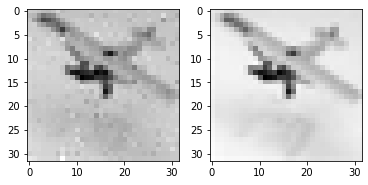

True label: 0
predicted label: 2
Time:  480.74757385253906  seconds
Initial fitness: 
 [-0.5062394659693457, -0.5026847130683595, -0.4643632481689224, -0.4997326027483673, -0.47068054803554915, -0.4999182767359559, -0.49671203561189303, -0.4246969585672338, -0.4277048132104731, -0.4404759904768878, -0.5066027529465043, -0.4840465026462637, -0.5406417427968366, -0.5546481836605475, -0.49545944226899197, -0.4629988245552394, -0.4915562605700088, -0.45209696118364223, -0.5243038593873115, -0.47689343885079855, -0.5443958449179419, -0.5140891642689014, -0.4938544162180104, -0.4859860847482742, -0.49954320519051826, -0.5012721244606984, -0.5176103535174634, -0.4706445001136703, -0.5075642704784488, -0.44577910435590606, -0.5093926160865228, -0.5233000904338458, -0.5397994124271129, -0.5182911500718042, -0.5186813256633086, -0.4770735269932108, -0.5624054980696321, -0.5028222014092131, -0.47765904533693126, -0.4812124454079958, -0.5516634117554173, -0.40748548860891687, -0.5017678075074087, 

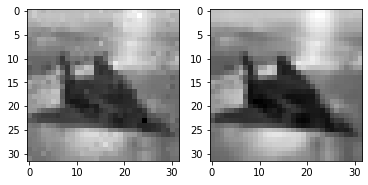

True label: 0
predicted label: 8
Time:  367.5763955116272  seconds
Initial fitness: 
 [-0.2838147715855197, -0.3620259432994569, -0.234125471435755, -0.3224155060698535, -0.34011447395720273, -0.2782663116773913, -0.32486351573244643, -0.4254917180466732, -0.3136231819361134, -0.3300653090679035, -0.2351955962977854, -0.36444676775346474, -0.36413742361758505, -0.3668417007847891, -0.06437858912481106, -0.29299157369779877, -0.4030045110037159, -0.4082644678343352, -0.3717764776026664, -0.3479601506092204, -0.27156976339515837, -0.2894145244287508, -0.33679012804306196, -0.36523362594443004, -0.22674790524212374, -0.3492584906109865, -0.33963946061374517, -0.417021742722806, -0.3366393936208896, -0.36566894234038494, -0.3321190496270088, -0.2808619055703585, -0.40284507487404553, -0.3481568989404458, -0.35012022753591676, -0.44403564588804156, -0.3292416148208188, -0.1782467652641755, -0.3471292362069315, -0.3399133954936163, -0.31775368552329275, -0.29278137915989155, -0.3468266570426

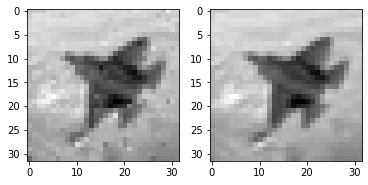

True label: 0
predicted label: 2
Time:  354.5691611766815  seconds
Initial fitness: 
 [-0.5918543518716006, -0.5948548219545016, -0.589677026383372, -0.5884525852865634, -0.5938783473970117, -0.5907768004802646, -0.5931659106551993, -0.5952900430989032, -0.5944872153794419, -0.5900535125271965, -0.5937140559146972, -0.5941674331550817, -0.5982704972653521, -0.5925993258119642, -0.593536336394626, -0.5947354131036477, -0.5951188611696459, -0.5886521737530154, -0.5944397593903895, -0.5939818408157342, -0.5931589259066528, -0.5940627606228125, -0.5976290839245475, -0.5959921955883055, -0.5939448936094043, -0.5910144616660127, -0.5924077661547789, -0.5906492978987036, -0.5921208694113519, -0.5966299756123317, -0.5947341295391059, -0.5975516051791988, -0.5957436839262252, -0.5944809773894689, -0.5944945107748415, -0.5915269053988368, -0.5943750048822611, -0.5939004177791224, -0.595737015899795, -0.5953214726560673, -0.5940448793317212, -0.5941411131570207, -0.5948641805556005, -0.5952351453

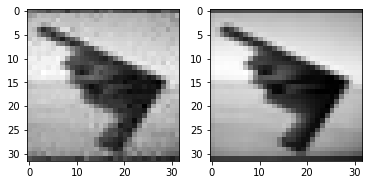

True label: 0
predicted label: 2
Time:  907.202107667923  seconds
Initial fitness: 
 [-0.5538860729006676, -0.5553993153173082, -0.554498711858712, -0.5357780113187924, -0.5135890586696341, -0.5329878828148169, -0.5220632058763937, -0.5692316962316764, -0.5328833840369094, -0.5765813080122292, -0.49644153802716917, -0.554201410709773, -0.526284838880463, -0.5320764976617122, -0.508222785631478, -0.565071801778916, -0.570457888598015, -0.540055969049904, -0.5038827220191215, -0.5302038758345953, -0.49022445862414, -0.5681494082499131, -0.5447150827472007, -0.5406054744889319, -0.5252414898679765, -0.5479839044730568, -0.5318493934379241, -0.5520560622527542, -0.5372249803534058, -0.5384435194991944, -0.4410592884710646, -0.5359607985541879, -0.4606714200247784, -0.5246966462102769, -0.4857797227247186, -0.5392272222615564, -0.5419202486014809, -0.5321773872811115, -0.4879072512062304, -0.5614162681440301, -0.5434536055572543, -0.5349228858947754, -0.5467056223452412, -0.4633399638154855

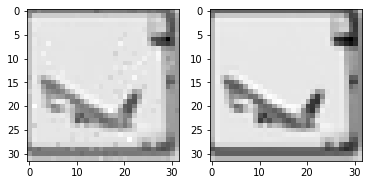

True label: 0
predicted label: 2
Time:  240.76416516304016  seconds
Initial fitness: 
 [-0.5946056368896877, -0.6115275061184409, -0.5755957935167685, -0.6000404903429057, -0.611303528221432, -0.5928396237042228, -0.6070756421691393, -0.6034592083886632, -0.5999033451972529, -0.6062520985258221, -0.608517786909125, -0.6146169278954519, -0.5939583582515443, -0.5995092714239907, -0.5977695017309193, -0.608723580848742, -0.6148530047524203, -0.6042059951764254, -0.6112585756212726, -0.5820868643864333, -0.6004966997602451, -0.5987679695512308, -0.5899915913347424, -0.5962625937897931, -0.599683631193916, -0.593532813534551, -0.6011457470081656, -0.6126013929608567, -0.6001043306064465, -0.5936200736778076, -0.5979533623839433, -0.5882447382083482, -0.598804266131464, -0.6182035949384616, -0.6018818040736997, -0.5952222355888915, -0.5970002436340106, -0.6039975863227499, -0.607611669523168, -0.6023271151132604, -0.5902557860502435, -0.6126555273667593, -0.5997918642425146, -0.5917592825647

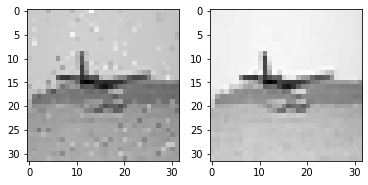

True label: 0
predicted label: 8
Time:  211.26054167747498  seconds
Initial fitness: 
 [-0.6044191416040439, -0.6026155047222801, -0.6011726694881131, -0.6026907535979531, -0.599890810983735, -0.6027348295558267, -0.6042945311826369, -0.6050492666662103, -0.60150816367735, -0.6066266834837737, -0.6049363544771337, -0.6031495571897211, -0.6034130610687756, -0.6045248796839242, -0.6084840948377543, -0.601756229295212, -0.6012705731936985, -0.6002459649724299, -0.600827688844358, -0.6005602481051324, -0.6042645980735378, -0.6038712557354166, -0.613513538159707, -0.6023631064199721, -0.6073364394833364, -0.5999339635643995, -0.6011854604386904, -0.6013252744082809, -0.6000314276873235, -0.6039834027563333, -0.6033412894644637, -0.6015452557119177, -0.6098695449819191, -0.6021720849700369, -0.6016069568672456, -0.6024546913040365, -0.6048427618989861, -0.605651317230698, -0.60254162537653, -0.6047242686120925, -0.6036797837990558, -0.6044363100023875, -0.6077005074094965, -0.600509017864176

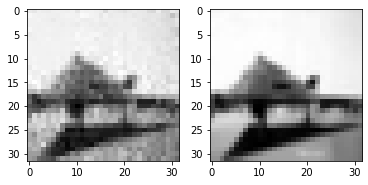

True label: 0
predicted label: 8
Time:  1162.0449821949005  seconds
Initial fitness: 
 [-0.5964260619273258, -0.5962762711707764, -0.5957971745244441, -0.5968597388597808, -0.5964740722212852, -0.5961488536569449, -0.5942614268569126, -0.5918327380002182, -0.5945222622848052, -0.5957706177876235, -0.5946417661257792, -0.5950263746125358, -0.5936454719465585, -0.5965717187438859, -0.5959274381480124, -0.5963874421114079, -0.5946298428068735, -0.5975192867327883, -0.5970567187129882, -0.5964621275352049, -0.5965492746755464, -0.5965054972954875, -0.596276974666635, -0.5936883917841751, -0.5972930635195984, -0.5941161633780645, -0.5965078385108022, -0.5966756781356508, -0.5953345577526719, -0.5945595668223376, -0.5937760121162616, -0.5959762590556699, -0.592598849382084, -0.5904716826039322, -0.5957630974322008, -0.5957088764789888, -0.5966474077829949, -0.5941166277672448, -0.5960845258744536, -0.596076880670532, -0.5964171455308591, -0.5965050863707432, -0.5936957169482167, -0.595301723

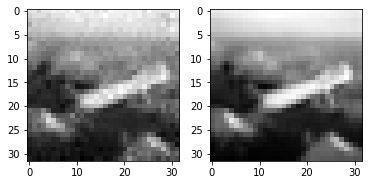

True label: 0
predicted label: 2
Time:  779.4971029758453  seconds
Initial fitness: 
 [-0.5763579722671547, -0.5802274712747455, -0.5806644289045133, -0.5697890828010249, -0.5847356432916525, -0.5802692196502723, -0.5712685079750165, -0.5502472533226364, -0.5772672339558597, -0.5693895206141701, -0.5716303426849243, -0.5921519210555075, -0.5801369264362668, -0.5898621931324945, -0.5602730788299627, -0.5811472767988947, -0.5775835559380557, -0.5834997585975682, -0.5846251291239115, -0.5777676300834679, -0.5738350908706733, -0.5891009529148578, -0.5775788518940407, -0.5836033197000876, -0.5752114919178379, -0.5787816922157956, -0.580428859034864, -0.5776222273447076, -0.5785262534560389, -0.5868321302868087, -0.5695952733109706, -0.581945565439978, -0.5695447397416482, -0.5853775158750611, -0.5898299025658081, -0.5801752994742959, -0.5714026553467564, -0.5705835572099409, -0.5820632950063234, -0.5763779991208531, -0.5769503968282712, -0.570117685185984, -0.5773091753634754, -0.5713742997

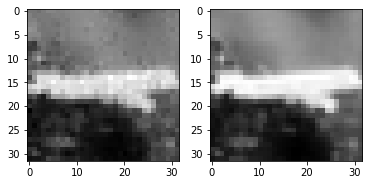

True label: 0
predicted label: 8
Time:  477.60193252563477  seconds
Initial fitness: 
 [-0.18127412158594292, -0.15860232590015347, -0.11957949812959928, -0.031774699903801024, 0.0803696658852362, -0.25159095709234475, -0.06965233463525825, -0.40314909104881735, -0.346850205635431, -0.2554297178679212, -0.21853334575140793, 0.000934657900361402, 0.12249695544400076, -0.027972462354735023, 0.09771316071815778, 0.011804295472748277, -0.15870512068680304, -0.28202146877201584, -0.11117021014237344, -0.3378075384149372, 0.002931147313901178, -0.0963219992015305, -0.2767594649637125, -0.270358731099557, -0.10542256608194833, 0.07798103085670523, -0.24739679683059532, -0.14326092104158755, -0.08962687544379705, -0.22916172356684017, -0.09837176689335286, -0.16082394239509268, -0.21288427370193358, -0.22568698416581404, -0.10200299969181681, 0.012872048450242146, -0.05627295328350965, -0.11568674072872498, -0.20754621629131853, -0.06796717519628453, -0.3251643247513206, -0.16289377260057236, 

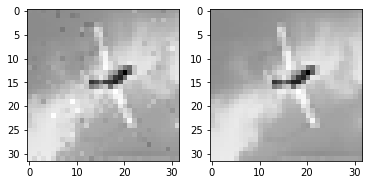

True label: 0
predicted label: 2
Time:  192.56694269180298  seconds
Initial fitness: 
 [-0.5091134469541153, -0.4425635893992605, -0.5751289792646259, -0.5550764658271528, -0.5306789871673205, -0.5042109186235065, -0.5101156729716966, -0.5183357845081675, -0.4473711480923088, -0.4986706786418098, -0.5041915359913612, -0.5264773232887476, -0.40550740140386177, -0.523825870590633, -0.5054863707038674, -0.4155739402387242, -0.3823233351307106, -0.5114833580099115, -0.3151314166149687, -0.5180424461216614, -0.49689242691093766, -0.5006452167792775, -0.4651304320828167, -0.49176919864236635, -0.5565280887527032, -0.514787130810542, -0.5160615919688232, -0.43033832402734434, -0.4956591305091185, -0.5442529232784769, -0.5296452764795062, -0.5030124631828307, -0.5394735299414352, -0.48066595465318496, -0.5268381373260383, -0.530901946554323, -0.2792572609982966, -0.5462280072019936, -0.5318077775747252, -0.44086976367708364, -0.5079743746946777, -0.5729644220477871, -0.5363113160562094, -0.540

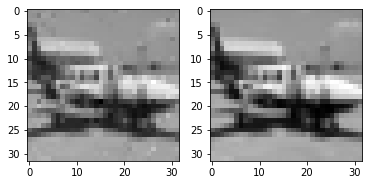

True label: 0
predicted label: 9
Time:  233.1107199192047  seconds
Initial fitness: 
 [0.4094686375370009, 0.39595252729399033, 0.5402734385288678, 0.3820710146523396, 0.49610882198824074, 0.4209089986508253, 0.41965639302757385, 0.5925109889170647, 0.561747629403777, 0.5054290436203551, 0.4105011695046229, 0.45756507872154295, 0.4007355644110595, 0.38365900957026783, 0.3309515481816708, 0.3798827862337759, 0.3985532154331667, 0.37810229141836016, 0.5222735914400747, 0.46056236455414434, 0.5088804524582047, 0.41487970387260614, 0.44883981820200103, 0.36202610359989734, 0.3804510942938515, 0.4403249825985933, 0.39503607148898623, 0.3908883615574539, 0.42320051269886355, 0.43618599712525996, 0.5838189795126061, 0.39352296211281956, 0.5076070652977942, 0.3485204268683346, 0.5033171084405206, 0.5605107243229813, 0.39937505126096307, 0.5264345357592689, 0.32041090888876256, 0.43435859484431605, 0.4306241980202089, 0.3623255528388946, 0.39193895307138177, 0.3953144285936048, 0.41193048361181

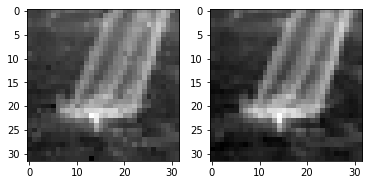

True label: 0
predicted label: 2
Time:  164.6685221195221  seconds
Initial fitness: 
 [-0.13664097847736056, -0.40817641356840484, -0.21672919718858363, -0.17771381428967098, -0.24536503285862987, 0.029856979358020452, -0.281836757900074, -0.168540149593162, -0.3174789855773074, -0.09038139767685327, -0.37872451356663017, -0.23281674930377402, -0.13827838126527708, -0.11886443348647147, -0.22502254517683254, -0.3865390716252608, -0.19877305259885822, -0.26889606973004127, -0.2233317148096654, -0.2271943079463035, -0.09453959817139063, -0.09700507575360873, -0.3385735718430689, 0.4328009094430278, -0.27456938830957345, -0.2163269963178185, -0.2265258672943665, -0.13959949102053448, -0.23820233157083945, -0.26217019717979295, -0.32330730155055765, -0.3119304421335162, -0.18895237060613126, -0.3878252119763296, -0.41912237290375803, -0.16451315549833745, -0.2095293229539501, -0.18076338133865233, -0.03731208530705807, -0.25758682402956407, -0.23066272679681873, 0.1298558995853718, -0.3501

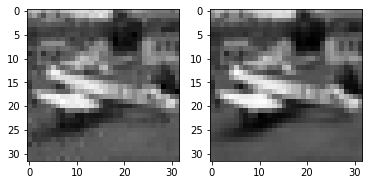

True label: 0
predicted label: 8
Time:  428.96221685409546  seconds
Initial fitness: 
 [-0.6009279247259914, -0.6012514195262904, -0.6013358823583721, -0.6013145418217631, -0.6034581954279772, -0.6026704565065719, -0.6008784460952767, -0.6016904046056744, -0.6016381537606557, -0.6009191932012504, -0.6025062081652863, -0.6024127406376861, -0.6009887330727964, -0.6017174848996711, -0.6019587473978503, -0.6033913513441348, -0.6023328289765573, -0.6021660788114067, -0.6015835784773069, -0.6016168030907169, -0.6006390902429913, -0.6032028747246747, -0.6031897109280426, -0.600637697124768, -0.6014859958704268, -0.60222023132024, -0.6016725772669692, -0.6039857227923698, -0.6005664487557489, -0.6000421374127585, -0.6024438945902865, -0.601210370503897, -0.6017141359532205, -0.6014254433943369, -0.6025521560122742, -0.6011444342452293, -0.600565551526406, -0.6015099201091733, -0.60161519435526, -0.6000294535737729, -0.6001237812770494, -0.6001702721815141, -0.6002273903411265, -0.6031191677824

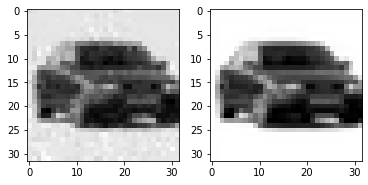

True label: 1
predicted label: 8
Time:  642.2359442710876  seconds
Initial fitness: 
 [-0.5384411379888833, -0.5575051411270091, -0.43712277673228567, -0.5428513571658844, -0.5491289061805609, -0.4863316609526086, -0.5589552926416916, -0.5388605850051738, -0.5186253394077681, -0.5466750521607062, -0.5534905675196539, -0.5325042241459454, -0.5346210146916759, -0.4779438016477582, -0.5768947274541083, -0.5608280445926523, -0.5719246244058639, -0.5547334528708019, -0.4990243485720648, -0.5651486916444242, -0.5307577230602941, -0.5521596792437263, -0.5355331490673898, -0.499158360569543, -0.5483320483188752, -0.5492078566208748, -0.5382754779748011, -0.5358032173891979, -0.5350016188637472, -0.4718995900685511, -0.5187364926124565, -0.4940855622998232, -0.5053071148072648, -0.5350622396539984, -0.5382040913405097, -0.5499803883702703, -0.45790443309964635, -0.4998144292793459, -0.46388602760985254, -0.48227558937964726, -0.5493957051902972, -0.5357402953422356, -0.5290605916484924, -0.5402

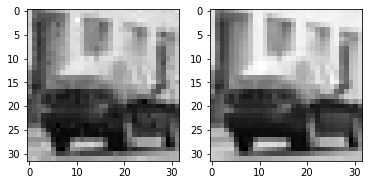

True label: 1
predicted label: 9
Time:  288.7614014148712  seconds
Initial fitness: 
 [-0.6025856354671212, -0.6040416599020642, -0.6033573063811436, -0.6009147214708903, -0.6021172826734563, -0.6045066423824488, -0.6019542389438839, -0.6046226986600387, -0.6018983843926999, -0.6000329759162267, -0.605859865163437, -0.6086981087488988, -0.6001577731673884, -0.6071086980958799, -0.6002603032171367, -0.6029644186552485, -0.6012119832809366, -0.6025611461838257, -0.6000674388512911, -0.600183562488608, -0.6011073992282445, -0.602155960155837, -0.6004895964406081, -0.6002579432724285, -0.6024225336126747, -0.600311197903612, -0.6003933014795557, -0.6014571553817974, -0.6021776938462714, -0.605743177169943, -0.6026185301074722, -0.6031028815185144, -0.6059479616665382, -0.6037221412088668, -0.6016271374192297, -0.6076878989062217, -0.6016287925857118, -0.6027482129828383, -0.6045811643609736, -0.605038591540979, -0.604644128226377, -0.6026545172437239, -0.6007063289895379, -0.60237084215372

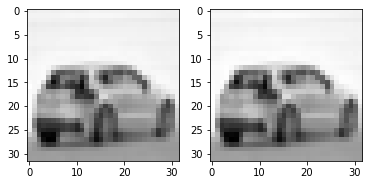

True label: 1
predicted label: 1
Time:  128.09183979034424  seconds
Initial fitness: 
 [0.48572970589098463, 0.418868194078972, -0.005078332249453643, 0.13936327991100578, 0.4865954993051768, 0.46452857020946015, 0.21088743609511418, -0.019073165527720704, 0.24677484802862343, 0.4536243949741973, 0.012421701104769922, 0.29201423174143964, 0.10431777913974333, 0.2247902751135739, 0.4674095691012066, 0.33634643524082153, 0.20241208209958864, 0.05615937888168068, 0.5967125946084949, 0.41366656793458256, 0.32195025173319214, 0.44800597939716125, 0.2992138966285364, 0.11221806498479349, 0.2844239107596288, 0.25242329309334877, 0.47358832840247134, 0.28713927308083553, 0.392410377446822, 0.36646763983013425, 0.4447222552743254, 0.6121762526686753, 0.6332249108713606, 0.37914096577036904, 0.45906696281510173, 0.46402276957983374, 0.16772873160320276, 0.34999454010911196, 0.43403684683069577, 0.3930481739874326, 0.521888979604524, 0.4387165551397194, 0.5242355398155593, 0.15236970857816887, 0.

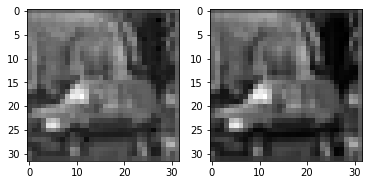

True label: 1
predicted label: 7
Time:  282.233505487442  seconds
Initial fitness: 
 [0.46169247026863697, 0.5041192751677429, 0.4928179084883289, 0.6169862592711924, 0.5047424368821493, 0.5634534714310188, 0.5995092896204735, 0.4966284685848812, 0.5681800752796229, 0.4970912338666289, 0.5836300906992791, 0.5441366657491704, 0.5381908027316906, 0.5762998294709585, 0.6194873624962547, 0.5528048978057349, 0.5118987757563649, 0.5139886819087922, 0.5854868923474025, 0.5307161462413128, 0.599883577408473, 0.6230540315127804, 0.6163733503009711, 0.5549558603231528, 0.5387352045897277, 0.5320161928838447, 0.48337842636607625, 0.5871098834839674, 0.5344584678328871, 0.652955014929762, 0.6998611119300884, 0.6286222337811708, 0.5933935635104157, 0.5307332502017894, 0.612420879603486, 0.5570259297876693, 0.3120045894600759, 0.6199323585240797, 0.573180993824436, 0.4822292803487681, 0.5272160226500571, 0.5327867028530698, 0.5170783270503607, 0.5215632911352023, 0.6464606910291513, 0.46846831001286

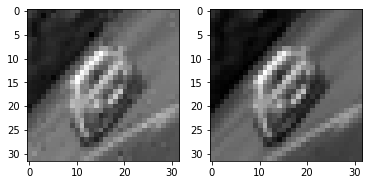

True label: 1
predicted label: 6
Time:  254.89120435714722  seconds
Initial fitness: 
 [-0.5835498548662517, -0.5931390272817813, -0.5943972909746917, -0.5948230203850112, -0.592872430381261, -0.5919025419796953, -0.5890650613860038, -0.5924392214166516, -0.5895271000480585, -0.589853578308726, -0.595619494996952, -0.5881441738452774, -0.5905567439648426, -0.5944347231328151, -0.5907443222710413, -0.592969190578364, -0.5876468757426483, -0.5934785023143703, -0.5836559069841281, -0.5963204527459868, -0.5939061542701373, -0.5938359067474936, -0.5913341333644895, -0.5924613592453137, -0.5936424169212651, -0.5862089391419407, -0.5955805378878622, -0.5888282743718984, -0.5955301285688046, -0.595153699291104, -0.593220081966538, -0.5945102907413821, -0.5911193214199534, -0.5935464220784981, -0.5840744080151862, -0.5966439571066817, -0.5876573359260208, -0.5960339990547906, -0.5811867436834034, -0.5894477403574407, -0.5931275604154301, -0.5906113492401, -0.5946652088194194, -0.594239426877022

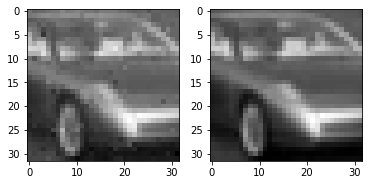

True label: 1
predicted label: 0
Time:  364.29598569869995  seconds
Initial fitness: 
 [-0.6000342340162467, -0.6000894790240892, -0.6000260151320858, -0.6000856333612034, -0.6000178000611804, -0.6001015049396996, -0.6000276200064677, -0.6000495302113403, -0.6000805311954023, -0.6001340819766295, -0.6000609620890376, -0.6000270210112744, -0.6000299529293256, -0.6000465332688115, -0.6000608693929558, -0.6001041374452138, -0.6000403115579347, -0.6000073635313754, -0.6000635398135774, -0.6000026643444009, -0.6000587953137126, -0.6000199977108138, -0.6000445114515702, -0.600076569336911, -0.6001178759165373, -0.6000700962547327, -0.6000202602981528, -0.6000378176833379, -0.6000190950030102, -0.6000811038212858, -0.6000255478037252, -0.6000531121141423, -0.6000508142842925, -0.6000474030323664, -0.6000497055054996, -0.6000057375472005, -0.60003052089127, -0.6000205276695757, -0.6000621568740316, -0.6000337105875325, -0.6000323955265048, -0.6000680856178973, -0.6000355378689709, -0.600052086

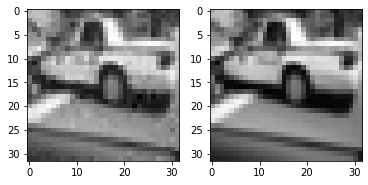

True label: 1
predicted label: 9
Time:  563.8595950603485  seconds
Initial fitness: 
 [-0.6000446860557254, -0.603359238113264, -0.6001558113715044, -0.600058971152436, -0.6014168919028129, -0.6004493105721052, -0.6000903868631117, -0.6007024962891335, -0.6005787668484327, -0.6006908125003441, -0.6000888831697431, -0.6001790398140827, -0.6002987803910718, -0.600305787707179, -0.6007010843589172, -0.6001806387082128, -0.60160436623517, -0.6001000707851349, -0.6001103628367834, -0.6001671596124015, -0.601418857777505, -0.6007094415781667, -0.6003357025693264, -0.6000919147570567, -0.6007978616112402, -0.6000839358551137, -0.6004186067505266, -0.600964054945554, -0.6003168100006825, -0.6000713742573971, -0.6009733122908906, -0.6003867751255656, -0.6009272346693081, -0.6003499489780305, -0.6007329017347055, -0.6002707291084195, -0.6001331495252462, -0.6000784851487675, -0.6001985422643296, -0.6000594407175447, -0.6003669135273835, -0.6002625051049867, -0.6000795986970808, -0.60056437289375

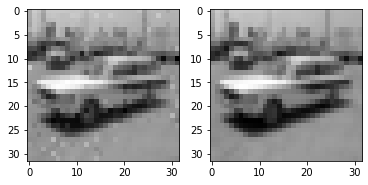

True label: 1
predicted label: 0
Time:  263.54889273643494  seconds
Initial fitness: 
 [-0.600035057200686, -0.6000171631751631, -0.6000539272262526, -0.6000296293680318, -0.6000515793845527, -0.6001421732241317, -0.600125582899588, -0.6000392467403065, -0.6000503046741377, -0.6000180457516118, -0.60002497050669, -0.6001110583755225, -0.6000371234471384, -0.6001124921212426, -0.6000676427093192, -0.6000781652790372, -0.6001338294078086, -0.6000912163927306, -0.6001104356387084, -0.6000974107764315, -0.600112846685906, -0.6000371691708729, -0.6000401570885661, -0.6000374968160409, -0.6000677233043454, -0.6000134431626081, -0.6000256087759053, -0.6001144418070652, -0.6000723263844558, -0.6000493310063604, -0.6001133888827426, -0.6000259720071728, -0.600131504122366, -0.6000894148982024, -0.6000341685575333, -0.600045342012449, -0.6000160458392774, -0.6000000054870073, -0.6000712603294678, -0.6001184770116328, -0.600014822051304, -0.6000241863299405, -0.6000422673652532, -0.60000993207441

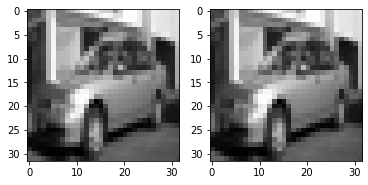

True label: 1
predicted label: 1
Time:  158.6416437625885  seconds
Initial fitness: 
 [-0.5995309071036841, -0.5994534904551398, -0.5995241915088815, -0.6001963854165087, -0.599155777182736, -0.5996610700603126, -0.5997762078968587, -0.5996818303462973, -0.5999016353727127, -0.5999263247391032, -0.5999261933656294, -0.5998780663411509, -0.5995904962401362, -0.5995800878467372, -0.5997580978828652, -0.5994789635864124, -0.6002629973673392, -0.6007677631355348, -0.60018591086029, -0.5999295702205625, -0.6002605729773124, -0.5999093997179734, -0.5996251987414856, -0.6000059297464433, -0.5997658163186953, -0.5998064567696813, -0.5997026765891247, -0.5992644235047753, -0.5996668886782194, -0.6000039278745938, -0.5996004841403277, -0.5993830394503965, -0.5991916759939746, -0.5999808935175062, -0.5995656838536075, -0.5997294935003729, -0.600359604519457, -0.600279522075633, -0.6001210345718807, -0.6004652829854054, -0.5998709835017364, -0.5996949018200708, -0.5995231653875904, -0.599656857116

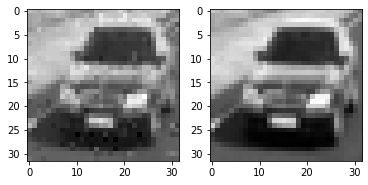

True label: 1
predicted label: 9
Time:  398.76526713371277  seconds
Initial fitness: 
 [-0.6002960354404715, -0.6000234229162775, -0.6002137241648788, -0.6002835382329291, -0.600365914561283, -0.600206177059215, -0.6001623756076863, -0.6001887182354104, -0.6001969327526704, -0.6000135963056511, -0.6002506123079334, -0.6001571169183777, -0.6001118852668226, -0.6002115374795147, -0.6002296750720447, -0.6000805591223026, -0.6000637581201472, -0.6000609507131994, -0.600190395544366, -0.6003885872342578, -0.6000295361107146, -0.6000759005849821, -0.6000448440190662, -0.6000713584485913, -0.6000413908357035, -0.60018035635775, -0.6002103891140479, -0.6006829112461222, -0.6001887495288778, -0.6002147727691682, -0.6001128885867366, -0.6003192433891033, -0.6000629960535685, -0.6000582686767072, -0.6000984766028422, -0.60014092214816, -0.6000898811554978, -0.6000358778709157, -0.6001834842804666, -0.600192316416516, -0.6001166202926572, -0.6005102537156216, -0.6001764518875378, -0.60006279582916

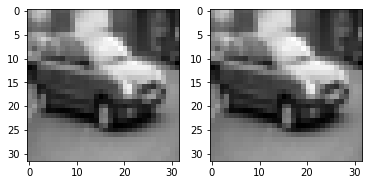

True label: 1
predicted label: 1
Time:  159.0236668586731  seconds
Initial fitness: 
 [-0.6000160749182537, -0.6000646115943455, -0.600006707747751, -0.6004375455876952, -0.6001367306346145, -0.6003372090015039, -0.600191285695766, -0.600536153334986, -0.6000704825331198, -0.6002116704820721, -0.6001851009041745, -0.6001591205233257, -0.6000044716419308, -0.6003821356170882, -0.6000791863592921, -0.6001750615826732, -0.6000888326250488, -0.6003567540555033, -0.6004708167359383, -0.6001276976691661, -0.6002007230676603, -0.600235511765195, -0.6006277396991349, -0.6000602465246968, -0.6005730670589162, -0.6001054127411137, -0.6001512309702776, -0.6001215946029099, -0.6003185995666982, -0.6005637643467439, -0.6002032490498748, -0.6002572983239443, -0.6001143402687076, -0.6000237303294832, -0.600066587656076, -0.6003788404831392, -0.600118783611779, -0.6000454867112707, -0.6000888537743918, -0.6003663318137159, -0.6002121051544225, -0.6006305802669946, -0.6001393233109799, -0.6003463434879

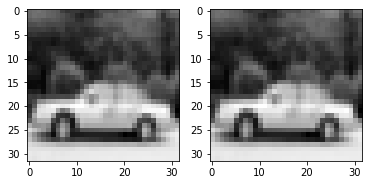

True label: 1
predicted label: 1
Time:  159.41809916496277  seconds
Initial fitness: 
 [-0.594199407925254, -0.593710743771501, -0.5932855117627198, -0.5941495514829027, -0.5953707783692975, -0.5916704253094536, -0.5881953851879808, -0.592291660363249, -0.5890218969979164, -0.5916379332399353, -0.5898683755730272, -0.5872182662526212, -0.5943875102535694, -0.5926975014436289, -0.5927677554209771, -0.5933518226193726, -0.5936186762774688, -0.5889581204833505, -0.5935544545560526, -0.5929236138948154, -0.5944620081853378, -0.5938159968223411, -0.5942805929650095, -0.5881657559559321, -0.5924252626816032, -0.5913331472759681, -0.5955679333083832, -0.593710237193606, -0.5914182981248913, -0.5943046936778413, -0.5904499727996926, -0.5957617093916864, -0.5949402420564835, -0.5898286066746794, -0.5931244117416066, -0.5929900581944484, -0.5883055916837852, -0.593301970414308, -0.5918525642849712, -0.5901945954675285, -0.594157656201606, -0.5931279397127249, -0.5911418618828519, -0.589000430031

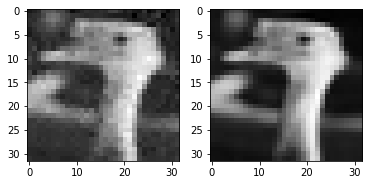

True label: 2
predicted label: 3
Time:  1488.9877593517303  seconds
Initial fitness: 
 [0.7273943494192924, 0.6094623794055815, 0.5412417312494766, 0.7840559434898744, 0.6404171869422938, 0.5548114473614353, 0.7408485537914753, 0.5109058448492059, 0.5893001710401948, 0.5624914022481431, 0.6859311386895429, 0.4730476222341805, 0.6460889557195586, 0.7436030438171706, 0.8201621421230482, 0.592084961865093, 0.759166813507335, 0.6765659495046432, 0.5776459485044675, 0.5697114421052447, 0.6923386162121588, 0.6399201731326745, 0.7263330833897629, 0.5787091986740738, 0.6008426731300872, 0.5743764105837397, 0.5520478831926999, 0.5608401367685962, 0.6128410140264081, 0.6542911650680205, 0.5149816909913693, 0.6164814564146104, 0.6747240324913131, 0.6006720743667351, 0.6545171969008209, 0.7741166901936861, 0.5180631621800278, 0.5649795780851086, 0.5988206005906683, 0.7438358105215065, 0.49331419660014864, 0.5227071755139314, 0.6021973596209687, 0.496393949802414, 0.6431788520231664, 0.761717624397

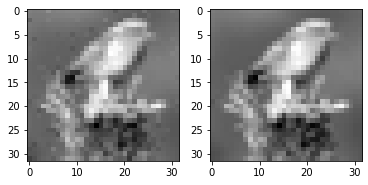

True label: 2
predicted label: 6
Time:  280.3379395008087  seconds
Initial fitness: 
 [-0.29905395678030056, -0.30452549229374015, -0.2667208707557267, -0.1965431697833365, -0.2817034912280233, -0.0491429372401061, -0.1623902077507055, -0.24731125646454535, -0.2648957497121387, -0.22615122101843593, -0.29000566746462586, 0.05465789294241771, -0.2477384276971118, -0.1322173791130315, -0.07591902909968157, -0.2103369948206223, -0.07409560752199082, -0.11749599902135574, -0.29520729611382157, -0.23506394498949829, -0.25693315947364426, -0.2594406917873978, -0.2440327203880955, -0.037099992790858904, -0.2671415223763498, -0.2779279185125433, 0.15814698654708403, -0.23153713389524727, -0.13316815436688997, -0.11621986404889875, -0.19088956858877384, -0.29363948299319487, -0.19997785094748552, -0.21785244748530705, -0.263500492870881, -0.23763708571105513, -0.24341655383486402, -0.33153209399845895, -0.2774970563427863, -0.2830983477649731, -0.17837308802719098, -0.3036275175261257, -0.28578

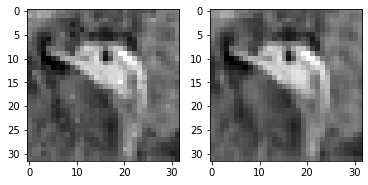

True label: 2
predicted label: 6
Time:  259.1595025062561  seconds
Initial fitness: 
 [-0.2484679624178782, -0.23495600253252133, -0.3811852112836772, -0.2436396487665399, -0.3568657837772531, -0.21431051184909589, -0.22911587024615798, -0.23087747896546026, -0.26850402506370086, -0.2955813766546336, -0.2711889934284316, -0.20026734702697363, -0.32576450195233453, -0.3502219180985804, -0.1806882655786746, -0.29528322075294133, -0.2614785914335352, -0.12575459386138654, -0.3849694609096694, -0.11238862287610785, -0.1654543034595876, -0.2703980068809747, -0.26743830135170044, -0.14669725793703425, -0.2627848917376408, -0.14835127638274734, -0.2908562154272616, -0.08395108488808761, -0.19335206697206206, -0.1931937737086845, -0.4138493959979621, -0.28639980851935465, -0.21344056164156786, -0.17052418670645436, -0.0001285241698029127, 0.01053217142127244, -0.12919083955736432, -0.25408013958408127, -0.24544511195567237, -0.13585987033108132, -0.31388205300680394, -0.15161123497973844, -0.1

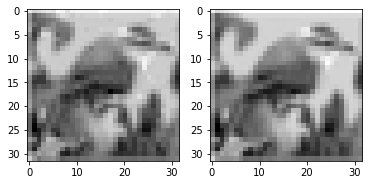

True label: 2
predicted label: 5
Time:  305.2480800151825  seconds
Initial fitness: 
 [-0.6000830456484859, -0.600458479259792, -0.6000058900864346, -0.5999836530359706, -0.6000920528529313, -0.6002649237730293, -0.5999764220999444, -0.600928162767973, -0.5999572763241083, -0.5998269748275479, -0.6002982564187914, -0.5998404383604927, -0.6002119230165058, -0.6007210065991051, -0.5999827659663213, -0.5998153643830246, -0.6015096191581076, -0.6013221943066567, -0.6007471319223964, -0.5999704404823998, -0.5999484350135176, -0.5997967285312205, -0.5999121456378563, -0.6008604970739639, -0.599894990903156, -0.6001062884618633, -0.5998996955386747, -0.6002330558181513, -0.5997780295351962, -0.5998099499595575, -0.5997996620259287, -0.6001222929800136, -0.6012722764268368, -0.5998128788772624, -0.6003894908946394, -0.5997971990894909, -0.5997052058516806, -0.6000656061944356, -0.5998876048458612, -0.6006173492847963, -0.5998798626733499, -0.6000343781868261, -0.6016426853353947, -0.5998164227

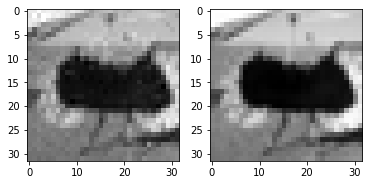

True label: 2
predicted label: 6
Time:  826.0578262805939  seconds
Initial fitness: 
 [-0.2529358701986383, -0.029402029944072344, -0.15937860228561412, -0.08342105007500838, -0.07076817253935777, -0.15696385104509936, -0.13339401633899217, 0.31144422429884744, -0.28771554671521243, 0.1460825570780573, -0.1914944349545019, 0.24217613425577944, 0.008892671918178607, -0.011779700018296119, -0.1938150458429626, -0.011802298073295414, -0.1972096489594565, -0.28242112839864175, -0.01871742378196281, -0.29754866321007567, -0.07915893280745873, -0.1486265498896239, -0.18746930141241847, -0.3448303162580238, -0.4473558922960549, -0.1441966595575996, -0.14772019101731587, 0.035471282970856555, -0.0019207843049008078, -0.10663668172301963, -0.21742086893539933, 0.35376838444820224, -0.07128108456906523, 0.14586843460157756, -0.1185390945641368, 0.09858441777330676, -0.07966344550370025, -0.28511079597944294, 0.0293929101632604, 0.25745767065404834, -0.20322473522009588, -0.14156458250844273, -0.

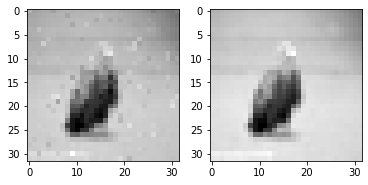

True label: 2
predicted label: 6
Time:  249.0669229030609  seconds
Initial fitness: 
 [-0.5947571725599152, -0.5955829300539587, -0.5961771578333926, -0.5973261935974193, -0.5975163250384737, -0.5943726492088203, -0.5937181412227585, -0.5951240038102238, -0.5951125514081183, -0.5870244370488065, -0.5968949734673168, -0.5965066489973042, -0.5951295058203944, -0.5972099568259165, -0.5946595199375855, -0.5969475909421484, -0.5959515730396784, -0.5953675493572012, -0.591343633596456, -0.5965973350555036, -0.590030060979335, -0.592767705597676, -0.596303846443056, -0.5912712241728669, -0.5956001606181605, -0.59543978971837, -0.5951511040972551, -0.5962297164751532, -0.595507207062389, -0.595742605922095, -0.5971148228371297, -0.594414072874405, -0.5975381992513293, -0.5928692612501539, -0.5964104532018359, -0.597732265246397, -0.5936742311775413, -0.5946919514246133, -0.5911444979122735, -0.5965983300665525, -0.5966214974737092, -0.5961122885111376, -0.5972264861218244, -0.595009530779124, 

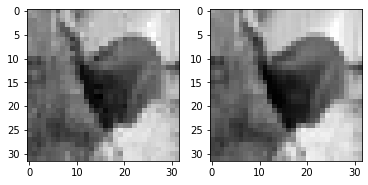

True label: 2
predicted label: 4
Time:  332.6808018684387  seconds
Initial fitness: 
 [-0.06583724165804558, -0.31829651097852363, -0.07809692049189335, -0.16568662016229455, -0.13449667470206575, -0.1159985339475946, -0.1680027084762499, -0.16006930382839768, -0.04079918923275816, -0.25512956510682216, -0.05087819456327411, -0.2042843315590279, -0.19796351937291656, -0.15524389219012766, -0.1962903886945165, -0.07159813968671719, -0.2675807788120609, -0.11297195172896707, -0.2847858495388012, -0.08298608079754946, -0.185604269825683, -0.2605059126857681, -0.04899965830589251, 0.02159036707881215, -0.1726196288675133, -0.05472044894391914, -0.14848734940261105, -0.14117490685900244, -0.088805836807646, -0.1306018998843531, -0.14540116898784677, -0.201326754574087, -0.21070317592468726, -0.06577583914328392, 0.033773734496761326, -0.1674638442530013, -0.07821781622857321, -0.05598746198323595, -0.05107460968531147, -0.09034025138975274, -0.1659549770035557, -0.15708749355671003, -0.2451

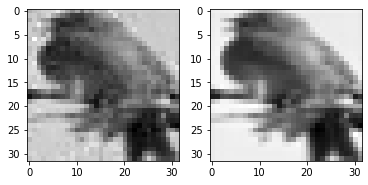

True label: 2
predicted label: 6
Time:  629.0426294803619  seconds
Initial fitness: 
 [-0.5726373030199807, -0.5782595565062871, -0.583225007285423, -0.5880486355680846, -0.5821461946808921, -0.577231360901039, -0.5869294056026497, -0.5835857941184901, -0.5816427226544952, -0.5637812624804253, -0.5715101584209074, -0.5907083706543412, -0.5832875984764674, -0.5733703264278249, -0.5844637205950939, -0.5853285936869852, -0.585387128532147, -0.5725501819119315, -0.5849963239477051, -0.5760830179827314, -0.5800296291558693, -0.5911182985057056, -0.5836275469107441, -0.5751735919282812, -0.5699639092896847, -0.5525599676608346, -0.5800170948062418, -0.565365417798657, -0.5711712293127353, -0.5821607323641802, -0.5816995729087141, -0.5812438471623194, -0.5673909967062591, -0.5759292908028274, -0.577819633570386, -0.5780914157528769, -0.5782103278610063, -0.5888808023355239, -0.583841917676341, -0.5828624421210713, -0.5825282669781472, -0.5733265185407906, -0.5725485744847236, -0.5822214099116

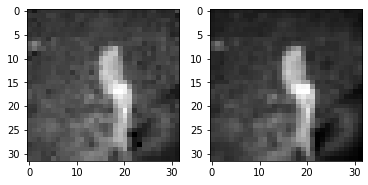

True label: 2
predicted label: 3
Time:  395.02580976486206  seconds
Initial fitness: 
 [-0.5529335294349639, -0.5701340535495345, -0.5623342450306881, -0.5611723588519537, -0.5634464283336393, -0.5585869022752976, -0.5422761180888361, -0.5645028298721394, -0.56526203976676, -0.5595324845480226, -0.5598754600162354, -0.574293690129291, -0.5637820105685634, -0.530405342718731, -0.5594538042606203, -0.5581835256077904, -0.5451362551221163, -0.565582468170261, -0.5652008738944387, -0.5453062306597694, -0.5683930403936692, -0.5607256389480717, -0.5598800678866064, -0.5590762249191175, -0.5697179784706005, -0.5481728406070959, -0.5612584948450383, -0.5319333411657023, -0.5603713502169647, -0.5541960816385217, -0.5414631960009457, -0.5586813363997503, -0.5583258518935611, -0.5655953063067956, -0.5684417065332754, -0.5633622733881396, -0.5428447643114851, -0.5471339298870431, -0.5557639749252612, -0.5538570009222037, -0.5642193352539023, -0.5215504744511559, -0.556023703632023, -0.532439920887

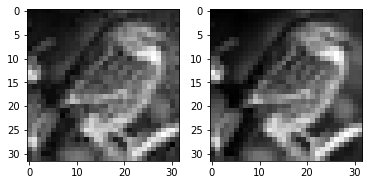

True label: 2
predicted label: 6
Time:  562.2517530918121  seconds
Initial fitness: 
 [0.9003377579772397, 0.8408188757677607, 0.8933885725346569, 0.9030280976960307, 0.8589102880339181, 0.8717641068241099, 0.931098938931377, 0.8968157237854216, 0.8901323556668866, 0.8996283261510041, 0.8680379015789662, 0.913462711780224, 0.749088587863305, 0.8333284532854837, 0.9104527089623715, 0.9024036069843634, 0.8892413864815413, 0.9091994172552587, 0.8996057827401753, 0.8983737909945015, 0.873975866673331, 0.9288628866446462, 0.8944997969973204, 0.8363946196450405, 0.8788152314479456, 0.85352858500679, 0.9159506173126513, 0.8330920758736866, 0.8762068193328711, 0.8666882056520396, 0.8910061933043973, 0.7962282020527379, 0.8565883493949598, 0.886208118799288, 0.8882481300967158, 0.8609222669710874, 0.8883472209474506, 0.8949161925383478, 0.8380930276581132, 0.8930297746560131, 0.8440894658784001, 0.887969103531415, 0.9146389864535504, 0.8705504267507868, 0.9048975878820175, 0.8940511046636354, 0

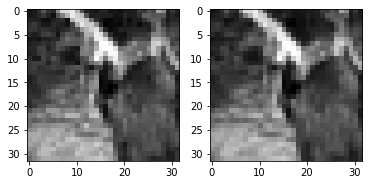

True label: 2
predicted label: 7
Time:  220.71569323539734  seconds
Initial fitness: 
 [-0.6117569725553562, -0.620819025568127, -0.6089150576895763, -0.6242295246227079, -0.6078728626470999, -0.6062720749627148, -0.6285273958825214, -0.6164023169188435, -0.6253887580618155, -0.6272803882666123, -0.6092335022578355, -0.620634418667273, -0.6140574062097862, -0.6127939958569413, -0.6177592775971665, -0.6183197305044742, -0.6105124192014708, -0.612906407968486, -0.6139069472513493, -0.6109454840045623, -0.627398139898998, -0.6128813963948488, -0.6167928251486279, -0.6255454333795196, -0.6191183539942698, -0.6066379002632282, -0.6117636682042702, -0.6141665961301335, -0.6185643208732039, -0.6049901277446122, -0.6197676118878886, -0.6128970619019503, -0.6313440223570896, -0.6056133824447745, -0.6310140171025238, -0.6126535309454754, -0.6044982814849954, -0.6121476140930358, -0.6153775992898222, -0.6115698512143735, -0.6227148982113766, -0.6091752174754186, -0.616496773007237, -0.60420707391

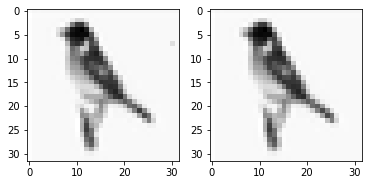

True label: 2
predicted label: 2
Time:  120.41248035430908  seconds
Initial fitness: 
 [-0.6002033886426885, -0.6007700686945758, -0.6002170595655179, -0.6001694663879618, -0.6001075142851886, -0.6002074371085959, -0.6001823488279725, -0.6000897595673659, -0.6004056880740603, -0.6001443627435481, -0.6000632929346404, -0.6006363237279994, -0.6001184964539014, -0.600043486866097, -0.6002548015076195, -0.6002069040415261, -0.6000157089044943, -0.6001898838762392, -0.6002248469834295, -0.6001645633724044, -0.6001815361108804, -0.6000785287353315, -0.6002389838431318, -0.6001388318517741, -0.6004219721728303, -0.6004371647276645, -0.6001136018286952, -0.6005026150576693, -0.6000612130456844, -0.6003319640334701, -0.60030759048997, -0.6003141565154552, -0.6005835357925353, -0.6006162442954843, -0.6000538641573415, -0.6003428284427088, -0.6003899643158241, -0.6006128079170743, -0.600050081854041, -0.6000999522383613, -0.6001984639848893, -0.6003420827557623, -0.6005595430603698, -0.6000406619

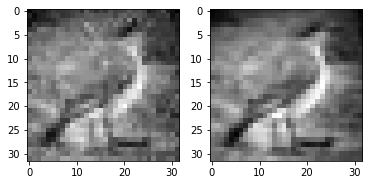

True label: 2
predicted label: 4
Time:  808.2264068126678  seconds
Initial fitness: 
 [-0.6001093514298301, -0.6021044517015772, -0.6027043322930267, -0.6011952758258549, -0.6010621807560567, -0.6005034896175775, -0.6008685780258689, -0.6007081331905086, -0.6011369818596728, -0.6022519742665758, -0.601954578812276, -0.6011314520566586, -0.6025690128545181, -0.6000036757011766, -0.6049119175466392, -0.6017305998923559, -0.6023339755047564, -0.6011857648460714, -0.6012671406330744, -0.6010939239214674, -0.6009752558013559, -0.6011596076516347, -0.6029331610492163, -0.6016307462282842, -0.6007334655876257, -0.6015518551992686, -0.6011444630776901, -0.6021327221995882, -0.6010119532042546, -0.6012408757589495, -0.6018043172599151, -0.6018336773083429, -0.600636540062912, -0.6014473591347734, -0.6030228394563293, -0.6031809163707942, -0.6010599509571977, -0.6002718816025165, -0.6001863204711604, -0.6004745440574494, -0.600475609723204, -0.6029487347697983, -0.6006571089279147, -0.6031911925

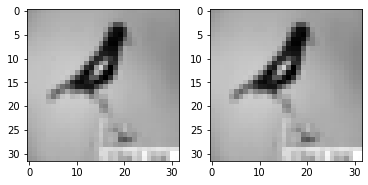

True label: 2
predicted label: 2
Time:  121.10726594924927  seconds
Initial fitness: 
 [0.9807753015262971, 0.988971986659937, 0.9862510896143508, 0.9890110905633138, 0.98855546426098, 0.9889863481652141, 0.9864326544028436, 0.9907901688812573, 0.9877375846245344, 0.9917830409667907, 0.9917608602156103, 0.9896368254314795, 0.9910742579806731, 0.9872275389697037, 0.9904226390972575, 0.9712197366676214, 0.9918944184764777, 0.9894678654419582, 0.9886397906279134, 0.9909349578013605, 0.9831002389382967, 0.9818054098669403, 0.9885150707590915, 0.9899143268733163, 0.9817972018204205, 0.9851197018023573, 0.9916725550159143, 0.9882606354977329, 0.9653306963279437, 0.991434831128247, 0.9911573503636657, 0.9878080539406476, 0.9845007049500543, 0.9893817930033795, 0.992334961411382, 0.9848534970118794, 0.9888757852159916, 0.9863206199868134, 0.9893586019769343, 0.9834771049640831, 0.9930523233303167, 0.9834773290096404, 0.9710303311782558, 0.9900613350114083, 0.9896930531471771, 0.988257345227086

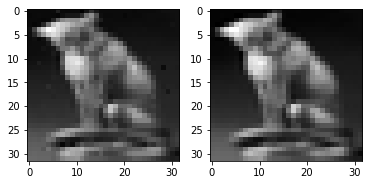

True label: 3
predicted label: 2
Time:  176.95045447349548  seconds
Initial fitness: 
 [0.37673480282096783, 0.24021644400507125, 0.3322230851162469, 0.011685991818838476, 0.45380368565735707, 0.3441256264790623, 0.30669825408725016, 0.4321264141518377, 0.04999548119116229, 0.2837831879196675, 0.3588682566131518, 0.16330497800930843, 0.09464675345379187, 0.30655715105551984, 0.43572960256013216, 0.03687590522155168, 0.48247122588692964, 0.3952865471948531, 0.33065170039208414, 0.2987623252617493, 0.17161193407764444, 0.25051719999078337, 0.3269187461390659, 0.20104847836535822, 0.2581590549037596, 0.36118289632191014, 0.3076426702215769, 0.37944321043344353, 0.2002775023889686, 0.4041652267741808, 0.11298518939813633, 0.45155389237086535, 0.3440654732788606, 0.1278399982133851, 0.37949280961676746, 0.233200984178694, 0.26902741354020737, 0.21760508460507025, 0.2180808800442224, 0.3995593975931168, 0.34360081610685644, 0.15128108591435582, 0.2478587763924843, 0.3777513883301653, 0.27421

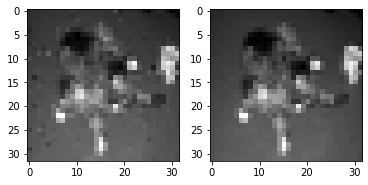

True label: 3
predicted label: 0
Time:  286.6214189529419  seconds
Initial fitness: 
 [-0.3093201152495436, -0.26574818005672146, -0.29527800604860277, -0.24308696857693407, -0.2755039084435423, -0.2186763135062421, -0.2237536817390265, -0.2865327089354516, -0.2813471536962001, -0.2964265634320842, -0.27502477569699213, -0.2559780421623974, -0.26567913307947394, -0.3990917017822805, -0.18247753235709585, 0.029729923156880084, -0.11602149955926183, -0.2904692145797976, -0.29637404837851156, -0.19831029473284087, -0.26007800950199644, -0.3044847230087055, -0.30009587787447495, -0.29006210977243124, -0.24879883129224914, -0.3536180868216119, -0.27010951550797624, -0.27972650420361245, -0.29678369008680044, -0.2089700153397155, -0.30372424325780645, -0.1769331725375114, -0.2964136781097925, -0.22371072393938318, -0.30580423319006955, -0.16664455019114507, -0.1731184359847504, -0.29821969839186546, -0.2593717905194415, -0.2442944637694437, -0.2785038131930119, -0.14387193379383342, -0.26878

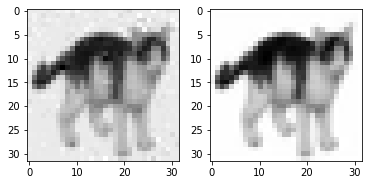

True label: 3
predicted label: 5
Time:  534.2733438014984  seconds
Initial fitness: 
 [-0.5742074248945258, -0.5567551275920976, -0.5719900033216153, -0.5491649760112344, -0.5742634425984945, -0.5579267091672864, -0.5811798295633859, -0.541586126285451, -0.5674608934083553, -0.5559382690539304, -0.5665256985475674, -0.5605789275006071, -0.5624702775946872, -0.5729610225568043, -0.5648627518958433, -0.5606560069195989, -0.5664496380340879, -0.5650727310197665, -0.5663499540553381, -0.5591186530228099, -0.565275088298258, -0.5492160677010952, -0.5789550269454236, -0.567975028156194, -0.5601479095218018, -0.5292543901729455, -0.5586036433123651, -0.5667318806530286, -0.5649009287987936, -0.5786056461147591, -0.571614292718698, -0.5610122723071433, -0.5671108365479463, -0.5577761683442928, -0.565919700458134, -0.5740765808280601, -0.5625230723213426, -0.5574899477354464, -0.5671441809381076, -0.5611122556049636, -0.5636542757785672, -0.5752251097721953, -0.5646594724595922, -0.571612579547

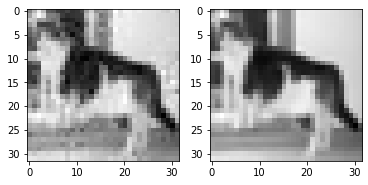

True label: 3
predicted label: 7
Time:  736.1707723140717  seconds
Initial fitness: 
 [0.7073469710575343, 0.5990700907994352, 0.6545233704581853, 0.6464670635624897, 0.6554380035458454, 0.6297257640394369, 0.6250378812482004, 0.5111615802990231, 0.6656295429192909, 0.6544828479374, 0.5926465069341537, 0.6230857976314368, 0.7090999821650721, 0.6720213367485803, 0.6421394450685902, 0.7064572069426858, 0.6488924387620101, 0.6835017162180914, 0.7111467439696163, 0.6620557727057357, 0.5944994477652636, 0.7823527927842997, 0.7439266518723527, 0.5535052251546777, 0.6132452796052418, 0.5586510889078815, 0.6820719283709737, 0.6326199322233561, 0.6721817986249607, 0.632495792487177, 0.6739855274149966, 0.6455518285050359, 0.7294804126644698, 0.6070237013931485, 0.6729613789362, 0.621027557143258, 0.7264150751737186, 0.5953196075571173, 0.7303684112551914, 0.7077734173501611, 0.75005795957838, 0.7054738214105019, 0.6471016320055696, 0.7213729123646853, 0.7738398290725703, 0.601474555822876, 0.73

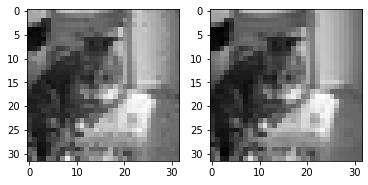

True label: 3
predicted label: 2
Time:  292.826828956604  seconds
Initial fitness: 
 [-0.17158433754970537, -0.3108024802086572, -0.3306246790943782, -0.29450298001953495, -0.16986850328758238, -0.2788765967341535, -0.20777936393257168, -0.26433765797511055, -0.3100963323587278, -0.200969287549517, -0.30479129199399135, -0.18530755027675003, -0.21601807707857806, -0.2506688434534673, -0.2267466470923475, -0.31659858808767627, -0.2107010169760806, -0.21214272664411, -0.22411996450945876, -0.24937203598164182, -0.21763713583537583, -0.24617986377041856, -0.2446681425402104, -0.28508051039345034, -0.14772464215204711, -0.17848937418424984, -0.1837866347224494, -0.2619779174619983, -0.29207278221539035, -0.04107789172824233, -0.25657795801188366, -0.23449927487237207, -0.29938109992789563, -0.3005652461859394, -0.2995873939103721, -0.2714037220877329, -0.27964491069057795, -0.2961554894126729, -0.17607345169538507, -0.1616067790096566, -0.31438517932317506, -0.26895961899689513, -0.3160044

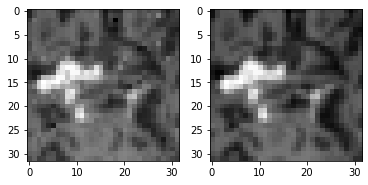

True label: 3
predicted label: 6
Time:  223.8006021976471  seconds
Initial fitness: 
 [-0.5895046445781869, -0.582975681865742, -0.5908715542486829, -0.5906024973059245, -0.5912386855868595, -0.5870828179639065, -0.592870585538461, -0.5840752703641312, -0.5788786771413252, -0.5857799482500992, -0.5848975148813627, -0.5829136652960389, -0.59033456616701, -0.5812575640694965, -0.5859019994564715, -0.5924683978530869, -0.5885348355904522, -0.5918075738011465, -0.5837896330667205, -0.5807985371969261, -0.5824762390889557, -0.5849726054772887, -0.5794671052431228, -0.5875206012808908, -0.5858740416139624, -0.5846306746796119, -0.5885420153884173, -0.5858965483601248, -0.5870090540925339, -0.5827090046744006, -0.5860077187697507, -0.5865477699123505, -0.5843682960795574, -0.5837399017913261, -0.5851517732961479, -0.5844393432718938, -0.5830464159357276, -0.5885283746696238, -0.5833083145637373, -0.5854417393253288, -0.5781152986542186, -0.5819475841997005, -0.5762985956132363, -0.56142463084

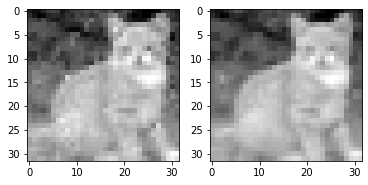

True label: 3
predicted label: 5
Time:  458.10738253593445  seconds
Initial fitness: 
 [-0.37346063607709223, -0.40088586505301027, -0.27309009515139426, -0.357895485086112, -0.2542182300999879, -0.34220937470661084, -0.35090298486863325, -0.38408104175582347, -0.2590704356018747, -0.3144255364368841, -0.2104649806742609, -0.2807579975997342, -0.35744391234175577, -0.3553565370110088, -0.344739019729724, 0.14878317706294422, -0.24149204724773154, -0.25972651051769136, -0.2620230957968338, -0.08598616291965816, -0.3819397151725189, -0.25417147054340633, -0.36887303999517784, -0.4586846719355909, -0.0781306973363653, -0.25673181750994667, -0.42006776801068824, -0.39717151310701204, -0.3852015939457353, -0.18833061075049803, -0.26013938177361484, -0.4087980828765102, -0.3456248840418855, -0.3503557532768651, -0.17350024152614732, -0.2331427211900415, -0.385126449494543, -0.23609503689790876, -0.34324084422928214, -0.39861203778304105, -0.15229545360815377, -0.29452916788472233, -0.3594637

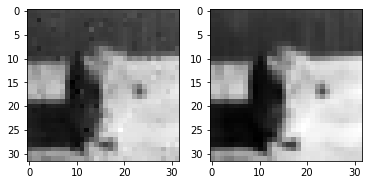

True label: 3
predicted label: 7
Time:  250.8264012336731  seconds
Initial fitness: 
 [-0.585609743299204, -0.5875868989957332, -0.5931983686130786, -0.5840190694715549, -0.5906131671464634, -0.5829635196229949, -0.5828553102822718, -0.5754539167452164, -0.5763478868369917, -0.5876829813187241, -0.5631701476955169, -0.5895984199233792, -0.5827978125233162, -0.5877694930374957, -0.5797135277547144, -0.5917990724320968, -0.5884327147285171, -0.580791671958069, -0.5822359302467397, -0.5814811787630612, -0.5734483237212433, -0.5842475310342689, -0.587526202741825, -0.5844578871764364, -0.5530616529115788, -0.5767494878166164, -0.581973803753072, -0.5887152758543464, -0.5787523935860099, -0.5783207230151544, -0.5738726088164158, -0.583849601784226, -0.5649044168020892, -0.5949100557212967, -0.5852116017146588, -0.5832586873317593, -0.5835996454274308, -0.5840203062377741, -0.5710409676317589, -0.5820745847224533, -0.5857234439812891, -0.5919871747182637, -0.5930030121595617, -0.585320496427

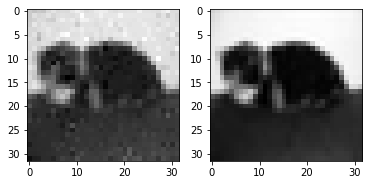

True label: 3
predicted label: 5
Time:  493.15164828300476  seconds
Initial fitness: 
 [-0.5448536503706949, -0.5485752393197627, -0.53349267789033, -0.5508873995218124, -0.5537499227588552, -0.5495857341588946, -0.5545970890650814, -0.5368200386512075, -0.5558319020291982, -0.5256664209363731, -0.5488854313228887, -0.5462329746805005, -0.5306181100444883, -0.5485016781573557, -0.5309122002032926, -0.5542704076312395, -0.5621424789093052, -0.5442509526907902, -0.5406464129414552, -0.5478700488540883, -0.5409580140818372, -0.5607108483319329, -0.5639733848246609, -0.554985977615186, -0.557649961763557, -0.5533146567453664, -0.5584257149050758, -0.5092986767999031, -0.5331466885238283, -0.5377199488395829, -0.5528157221690142, -0.5449844301855818, -0.533341821930714, -0.5255871275768771, -0.5166522931778498, -0.5308556483549752, -0.5511748475122651, -0.5625243247212136, -0.5301155203146113, -0.5482102257795658, -0.5504084205403753, -0.5582557228763696, -0.5612897228541737, -0.54261162173

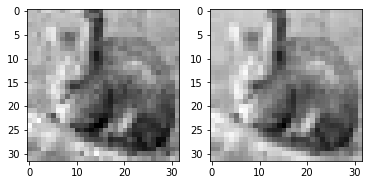

True label: 3
predicted label: 2
Time:  440.0611126422882  seconds
Initial fitness: 
 [-0.5103486585973842, -0.49674395315616793, -0.531432811840468, -0.49587187238324054, -0.5165396287939626, -0.5334937681082078, -0.5160243138059033, -0.5245362921784139, -0.4551106336750832, -0.4672578762960508, -0.45469464952257266, -0.5050808673404833, -0.4756080865885578, -0.5415690511295328, -0.503675098603323, -0.5308587611384321, -0.4975687143314088, -0.5121774475491143, -0.5327463077193004, -0.5462322723209518, -0.4872932148296558, -0.5187276273773004, -0.4666672078774182, -0.5300118977267573, -0.5131524439936951, -0.5304956170169433, -0.5135171454185907, -0.5304675354617391, -0.513038959382074, -0.49657000391893336, -0.5427835974871112, -0.5159282549737918, -0.5343071486613934, -0.5119834619349727, -0.5160272825040539, -0.48031382966720004, -0.4917994822047085, -0.5045486289434575, -0.5130500670706848, -0.503204328291978, -0.5244465757268739, -0.49611561404771715, -0.5179796783302305, -0.49396

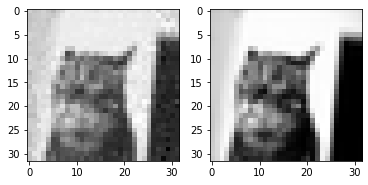

True label: 3
predicted label: 2
Time:  820.1819531917572  seconds
Initial fitness: 
 [0.8328979872611652, 0.6426347884631621, 0.8247402110964333, 0.6996495131107915, 0.7634817299869958, 0.7865795459863586, 0.6659732868263787, 0.7869094739932018, 0.6538224123231668, 0.6101910209581595, 0.6570056297672564, 0.6821102628381647, 0.73963481133662, 0.6399216661242351, 0.7624593625069294, 0.7115014966862014, 0.6797775163975747, 0.6820302872025286, 0.6823531867392895, 0.65407196194353, 0.6406867474990122, 0.715399262009868, 0.7843340045188165, 0.6108795089252478, 0.5915461718991726, 0.5942418976766671, 0.7419832002287793, 0.5649636223011774, 0.5728472108094705, 0.6797045801518664, 0.6391662900669448, 0.7552882336327217, 0.6859651154806867, 0.6630784044935714, 0.6670491483492887, 0.7994598505399689, 0.5994542846353653, 0.6642723590774787, 0.6394211609856268, 0.6098564863672974, 0.5890939426794094, 0.6867912017950588, 0.6413746963902931, 0.6892849105749821, 0.6082576307058212, 0.7440306106723111

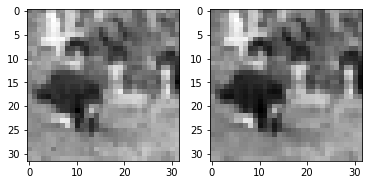

True label: 3
predicted label: 2
Time:  244.21570539474487  seconds
Initial fitness: 
 [0.3134848909233225, 0.3557776485061613, 0.35850654533551896, 0.47997783051987186, 0.3062380113743881, 0.43009857085577413, 0.40907595258720897, 0.3625343720353925, 0.2343117223280177, 0.2864118337989868, 0.2879523018518793, 0.3481613127705726, 0.35078630177641634, 0.23020782272113002, 0.35304947200986364, 0.29340448518948986, 0.45492276967747924, 0.2700578219820996, 0.32523482343011656, 0.3002390685044276, 0.34677540899917925, 0.3708393401055051, 0.5252286757707738, 0.2993976554498423, 0.373325627074117, 0.3981450166048236, 0.3952237501790627, 0.34765737370579264, 0.3847935479666281, 0.34455860258745086, 0.32784645152979514, 0.21018799007899072, 0.28711565362640695, 0.3653285919650682, 0.34730348733726113, 0.19823692635498713, 0.46367236550313384, 0.3254408232729193, 0.2881559840518705, 0.21708837460766633, 0.2697168430030486, 0.28170598525956525, 0.2747357527650325, 0.24354498226973714, 0.221585481

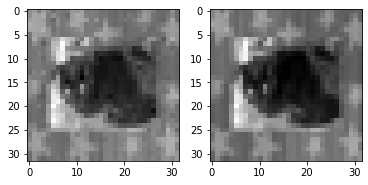

True label: 3
predicted label: 5
Time:  235.25544953346252  seconds
Initial fitness: 
 [-0.6000155559918585, -0.6000265104853552, -0.6002469404722789, -0.600004886028273, -0.6001029405161172, -0.6000850241789829, -0.6004377523189296, -0.6000201498227374, -0.6001209786217584, -0.600389952486963, -0.600041995799272, -0.6003461280864181, -0.599994692925372, -0.6001378410696284, -0.6002543883624749, -0.6000952932441469, -0.6000902659927078, -0.6001925572859984, -0.6000229149352283, -0.6004413478030851, -0.6001453844300776, -0.6002175141811052, -0.6006497418042182, -0.6001185245409434, -0.6000036612127448, -0.6000426233598541, -0.6005376403493695, -0.6004583760343494, -0.6000457388616982, -0.6004931795313131, -0.6000920277284141, -0.6002027352838488, -0.6009249111132716, -0.6000585317038512, -0.6004142336246125, -0.6004269571090228, -0.6012570677879336, -0.6000578857037132, -0.6000720156236787, -0.6000064348938203, -0.6004760234634627, -0.6001455929294486, -0.6001468753526569, -0.6000585331

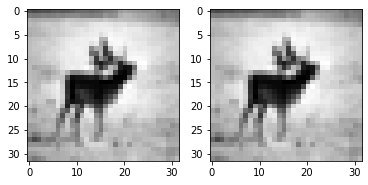

True label: 4
predicted label: 4
Time:  113.93559193611145  seconds
Initial fitness: 
 [0.6574265577566474, 0.6407462328180356, 0.6435985063897682, 0.6489872545619332, 0.4838887637165721, 0.6894201953845448, 0.6740478814019308, 0.5573492939424968, 0.5952143769923148, 0.7435251449597607, 0.6741375306162085, 0.7634556239356662, 0.5677237820479017, 0.6892639194336285, 0.6462030904210672, 0.7059214468092114, 0.6884044579962108, 0.6773604054011124, 0.5854529507932942, 0.6648714503238853, 0.7644134304906778, 0.6034861750116242, 0.6972031344287529, 0.616931462888498, 0.6536921640232678, 0.4746046159662267, 0.6522721062449817, 0.7224905815651737, 0.31426222350090666, 0.7304015692367092, 0.4991333017489265, 0.4787371242397684, 0.6144441836286296, 0.575171829147093, 0.653779359567397, 0.6986516372791355, 0.709767763871573, 0.5956822794269185, 0.6415848697513027, 0.44588287540209837, 0.5380630196006819, 0.5927937509677278, 0.6018916934245848, 0.738557678937488, 0.35619750446424603, 0.681511787766

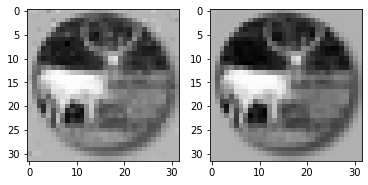

True label: 4
predicted label: 1
Time:  212.98444056510925  seconds
Initial fitness: 
 [-0.4661946351177873, -0.3761431371797195, -0.47098354791773545, -0.44513030457952774, -0.41584920772922024, -0.4379843802144716, -0.4937255603353832, -0.49242714990543346, -0.4854266833468531, -0.4070644670870563, -0.4583936252488572, -0.4452522444703372, -0.4524410170758921, -0.5495314163993381, -0.4334280560083288, -0.4785743151504488, -0.3185300653464417, -0.5240023820015648, -0.47975768471593283, -0.5417945843445395, -0.47240438172777, -0.423715106776131, -0.5054951142043288, -0.4958203681749484, -0.4190599077391014, -0.44712227444846875, -0.42807860605729464, -0.44571016829928367, -0.4946999607365653, -0.47861921326653045, -0.41955063652265423, -0.4422480845793295, -0.33417127863412177, -0.49286884273760034, -0.44623133258114756, -0.4244292419602913, -0.40035058806114515, -0.49683486434911883, -0.4144325010789999, -0.5121954787078543, -0.5134093266855524, -0.43270052367386225, -0.48847446108045

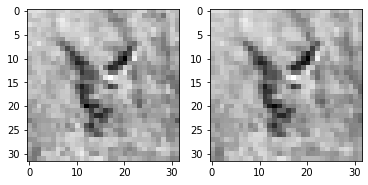

True label: 4
predicted label: 2
Time:  264.9067106246948  seconds
Initial fitness: 
 [-0.5949170848306579, -0.5986888947552031, -0.5942816902973153, -0.5944362041556699, -0.5889198666131118, -0.5946409387398877, -0.5939642861462706, -0.5950645269929512, -0.5927781510089931, -0.5921539217081266, -0.5940214363604218, -0.5914542371855875, -0.5926858041668637, -0.5928281510093505, -0.5928138678306426, -0.5958135295567338, -0.5968950582330531, -0.5914768116004704, -0.5961300916782462, -0.5956153901618383, -0.5937889332872146, -0.5954109022404598, -0.5942172296887758, -0.5946412468782707, -0.59630252095702, -0.5958432563712196, -0.5895501527787512, -0.5924054777392669, -0.5889909316907547, -0.5928981008664671, -0.5958565814283179, -0.5946953392037416, -0.5955369879011946, -0.5926884731223087, -0.5912085514467389, -0.5953557648787912, -0.5968348559262758, -0.5938928351277097, -0.593047351137719, -0.5950072845522223, -0.5950896368736492, -0.5914282905940305, -0.593429530833774, -0.59681062828

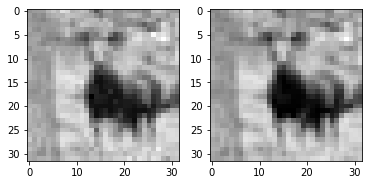

True label: 4
predicted label: 7
Time:  287.2785882949829  seconds
Initial fitness: 
 [-0.5480431100930876, -0.48284261883928237, -0.5368632270645626, -0.5307828894370917, -0.5356658422147159, -0.5098777295790099, -0.47821150122910094, -0.490754276080017, -0.49500133856333384, -0.4425973842341234, -0.5700298438246342, -0.399911353067244, -0.42643271903222946, -0.530736358149393, -0.49871673879611855, -0.4028192490134661, -0.5250834602328454, -0.34747830649672573, -0.4910642148947858, -0.5253484897617785, -0.5129048691938423, -0.48353458692506734, -0.5514880050330997, -0.5323994538688348, -0.5440519457519066, -0.5795024042633193, -0.5465298948735254, -0.5305389205660958, -0.5638600757272183, -0.5183174029979914, -0.4904474330798998, -0.47625621184476463, -0.5760911191770925, -0.4956834357651781, -0.4467172969916384, -0.5469744939336106, -0.5635494899156279, -0.5255438051986012, -0.3294259248678789, -0.5716824689583891, -0.5140383043270841, -0.5101527528201171, -0.4913771966978293, -0.51

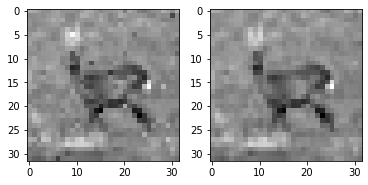

True label: 4
predicted label: 2
Time:  148.7395143508911  seconds
Initial fitness: 
 [-0.5956887883924101, -0.5903211580467229, -0.5852778867014877, -0.5907513779042372, -0.5933480298357017, -0.5947791567119896, -0.5950789484703818, -0.594962373537602, -0.5894411032144028, -0.5963939877836797, -0.5966438387284655, -0.5962182988039118, -0.5944967542069712, -0.5933482991858889, -0.5959244467891559, -0.5943317992360965, -0.5953322761123784, -0.5910659263661338, -0.595167324085131, -0.5935133233860519, -0.5908914237827555, -0.5949775373062998, -0.5966862813614344, -0.596819688787828, -0.5894387464377966, -0.59560822951548, -0.5945139467563821, -0.5938074657319271, -0.5947633450250026, -0.5951653993929739, -0.5925655020486715, -0.5885562644959695, -0.5958771502001823, -0.5965213833430177, -0.5934846262217073, -0.5960791864407092, -0.5951721819999185, -0.597484303322267, -0.5937026104741193, -0.5944174816610317, -0.5933352706026275, -0.5943851993937125, -0.5960330400032027, -0.5824136475275

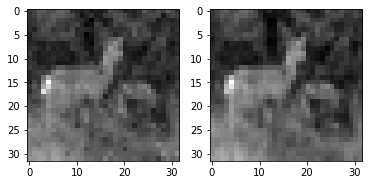

True label: 4
predicted label: 2
Time:  197.17897391319275  seconds
Initial fitness: 
 [0.3589409692769513, 0.27187461611328584, 0.15309262833056644, 0.11954361896017136, 0.40235022124890807, -0.2207998357906825, 0.29347334300692024, 0.11250476890478422, 0.5031189256914802, 0.17881044848724195, 0.1509511880182012, 0.36207089230157896, 0.3241193679354479, 0.19387295455402023, 0.08837767290520294, 0.17997782361275627, 0.42744147885097616, 0.3323559567193304, 0.2831749879147383, 0.3740443870589636, 0.38635483382380487, 0.2262100439207975, 0.27940334897378577, 0.12574590848551312, 0.5123334757127522, -0.014098973528689662, 0.38421184005861375, 0.2162751135630613, 0.3363714708147786, 0.3738261890713668, 0.5144121383420351, 0.4143703464023417, 0.644306189377099, 0.4677583256137122, 0.22145125775317606, 0.3314707566093197, 0.5576832200766804, 0.27434152272356216, 0.5068542621758715, -0.16935348058665456, -0.11812649149404089, 0.2595533094592038, -0.00558789674684787, 0.2199353031508582, 0.326

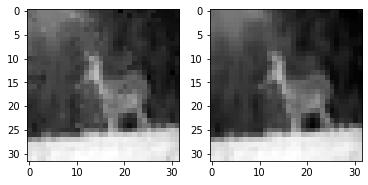

True label: 4
predicted label: 3
Time:  223.1807701587677  seconds
Initial fitness: 
 [0.9968880391754897, 0.994577655602268, 0.9953974156551446, 0.9966924741830141, 0.993716001160589, 0.9954451377231839, 0.9919939390966535, 0.9930922443170928, 0.9952191153754747, 0.9937461203020049, 0.9870607880765094, 0.9935513462245548, 0.9962365677659926, 0.9944696808528449, 0.9961859293009934, 0.9969798274192577, 0.9925000921741426, 0.997336900306563, 0.9904224034582697, 0.9978478525022321, 0.9934129876348956, 0.9891744105523702, 0.99592072671145, 0.9956615005444481, 0.9946118423997907, 0.9906520558981609, 0.9961610996337459, 0.9976799266871379, 0.9968606180900861, 0.9950290453122798, 0.9962142442869135, 0.995257014706858, 0.9950037385009782, 0.9953536256372866, 0.9930894434683246, 0.9918233216902729, 0.987696560533845, 0.9956130740221554, 0.9942905005059803, 0.995588284505224, 0.9945399363800848, 0.9964938908838502, 0.996155372725222, 0.9935690126586401, 0.9964381712569181, 0.9956335793654982, 0.

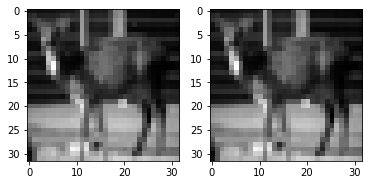

True label: 4
predicted label: 7
Time:  4.574310302734375  seconds
Initial fitness: 
 [-0.5684617600800836, -0.5615643852163695, -0.5589874069861894, -0.5654747269529089, -0.5671336570632234, -0.5595535091490416, -0.5636600440616923, -0.5677935755657224, -0.5618077062866562, -0.5686983634872863, -0.5498063971822129, -0.5635613750803304, -0.5600509608020239, -0.5734464304887094, -0.566857087887124, -0.5627129493022788, -0.5564552881542519, -0.5668615606104483, -0.570711779206386, -0.5582302392827688, -0.5716561649012684, -0.5659351756497596, -0.5600227872945196, -0.5503542043665567, -0.5620661299758056, -0.5673710763604681, -0.5523768693823955, -0.5574604014099326, -0.5679674138969676, -0.5492556234687207, -0.567994907054382, -0.5376041553629946, -0.5769171431989244, -0.5654202895803884, -0.5686021848807128, -0.5352746258788452, -0.5687658281591486, -0.5415316972837941, -0.555294559491581, -0.5768189558316335, -0.5665826691276205, -0.5594515813146833, -0.5679423353990488, -0.57308996296

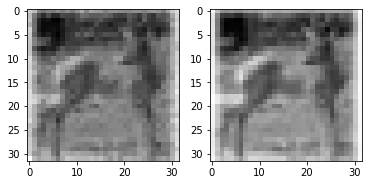

True label: 4
predicted label: 2
Time:  468.31048011779785  seconds
Initial fitness: 
 [-0.5898123312261705, -0.5941543860109442, -0.5953469977785721, -0.5938179717364911, -0.5925422274743712, -0.5931583147584579, -0.593653164243302, -0.5912962061272063, -0.5959654070451352, -0.5927172174646782, -0.5936083585279851, -0.5934045155818208, -0.5927125330463269, -0.5943475499990513, -0.5883597076139284, -0.5941627870219193, -0.5942569132826934, -0.5925993454574496, -0.5907528964577327, -0.5949906889392933, -0.5944910181909216, -0.5921313023133027, -0.5905737486972864, -0.5911277949168626, -0.5882839095905253, -0.5911762454877946, -0.5923647197919075, -0.5943006360966488, -0.5952721614043188, -0.5928686737251472, -0.5902129457187838, -0.5934076987257209, -0.5919862603696077, -0.5938956302411057, -0.5927948680859909, -0.5944628597618019, -0.5957485556030859, -0.5945677079743596, -0.5951225264862047, -0.5927793704798926, -0.5954415342278188, -0.5936633288799663, -0.5941813532941516, -0.5930782

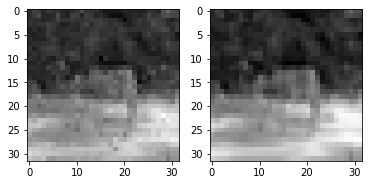

True label: 4
predicted label: 2
Time:  242.43427991867065  seconds
Initial fitness: 
 [0.14874325049512108, -0.06442913688972277, -0.2531913629700052, 0.005800290147846304, -0.14422479365534022, -0.049055034258295355, -0.14895143001309163, -0.022187312976299417, -0.04380483117953568, 0.10308544568605868, -0.11136595048825923, -0.14039449586650848, -0.12399023908930118, 0.052176314334864415, -0.3535235002425386, -0.2886897256562184, 0.02965802615012178, -0.18739710423439404, -0.4692122659533355, -0.08919672697568196, -0.1946821299633631, -0.16221590752515988, -0.18764490331570585, -0.02329418734119279, 0.06537601017798336, -0.055681064515112205, 0.18342493460093567, -0.07066218002653499, -0.15085685402231366, -0.14262485983135534, -0.10429690246172041, -0.1332179978843973, -0.042638672324243676, -0.16699608778425623, 0.008092618186377493, 0.07566926717781808, -0.0775281865307873, 0.013013562324931421, -0.09132786388488151, -0.13470304815440703, 0.1700476240090475, -0.16028634170463701,

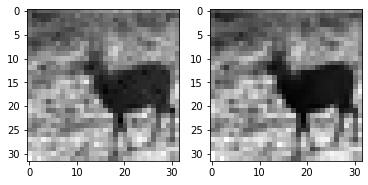

True label: 4
predicted label: 2
Time:  376.0176045894623  seconds
Initial fitness: 
 [-0.594038100922474, -0.5967392537087737, -0.5920767904699598, -0.594561536987578, -0.5978101679891179, -0.5948218691712612, -0.5962211404005594, -0.593722373749022, -0.5953472572551084, -0.59532746933168, -0.5915703486178713, -0.5916601846484669, -0.5935907908238398, -0.5896459709299616, -0.5930110947626084, -0.5926851086574355, -0.5954781487543451, -0.5930037622509456, -0.5956243940452735, -0.5899970475879621, -0.5948714071343675, -0.5960351224421102, -0.5971609639585848, -0.5954350024070254, -0.5955197723525559, -0.5942176003991317, -0.5938984556515934, -0.5954629712681732, -0.5957354544936586, -0.5936010903299094, -0.5957438577304512, -0.5964270455816154, -0.5931028195866006, -0.5955265813108276, -0.5912993983595708, -0.5961600670333167, -0.5937014055282926, -0.5945655335382348, -0.5940531385752984, -0.5939924111968893, -0.5987587650237467, -0.5959015590391925, -0.5938827214729246, -0.596022438815

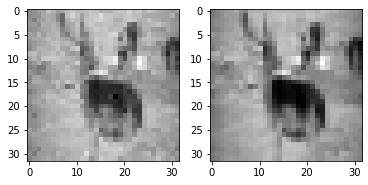

True label: 4
predicted label: 2
Time:  538.0703384876251  seconds
Initial fitness: 
 [0.44123167839673727, 0.35498010246224354, 0.4433770739128857, 0.41931101503071805, 0.3429297727303354, 0.4243650066648209, 0.3584234110514641, 0.38190436044262643, 0.39216946730015634, 0.3756842333055169, 0.37545803972514047, 0.40181431932137945, 0.39163903111870596, 0.44614273606933974, 0.39948811632987163, 0.432405937587943, 0.40838183558275365, 0.3278995383531025, 0.3054424425100631, 0.4353104739707165, 0.30323399218972563, 0.39855574763316637, 0.39489366881510934, 0.26740667965066955, 0.3616442509244224, 0.439857965676056, 0.44694496193356315, 0.3956907921903936, 0.37623073266705126, 0.429278964564767, 0.43919166163060575, 0.40758900095848016, 0.15454436362887441, 0.48287222821466713, 0.36894125985775217, 0.4941581014563815, 0.41794183597572265, 0.44456924355105365, 0.41676141221937135, 0.20083214126758622, 0.259000161240731, 0.3412730686777511, 0.41376153729179804, 0.40731141963910017, 0.4105694

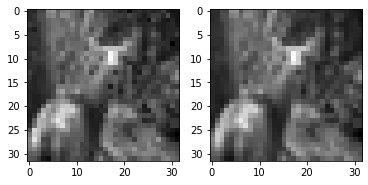

True label: 4
predicted label: 2
Time:  289.6375353336334  seconds
Initial fitness: 
 [-0.39921499114488573, -0.3774695109681744, -0.29874080547794807, -0.37665737148532585, -0.3337091081199407, -0.31421268714975403, -0.21437889181552938, -0.19302740513762823, -0.34082043258397676, -0.18364612775187955, -0.2642945102384811, -0.14325658550260423, -0.47951651243307214, -0.09869368766839054, -0.11870642357511418, -0.23583624020272048, -0.3099643911293646, -0.32478631295663973, -0.4042031529032637, -0.31298852022422796, -0.059520548949064556, -0.1656995794314565, -0.30997857145426916, -0.2760713190721502, -0.06880621863453709, -0.17624608265160555, -0.27637327389765254, -0.3932999487701806, -0.07507339163036256, -0.2318551473186433, -0.22888319396942908, -0.3005738414183729, 0.09451103041246293, -0.2932907439492115, -0.2877186571150656, -0.34645913978455745, -0.3445425536267922, -0.21802762135471407, -0.2302642743860854, -0.030167825789666397, -0.1949309965589451, -0.046447101335982705, 0.

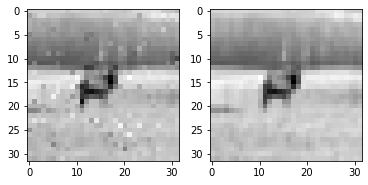

True label: 4
predicted label: 2
Time:  244.7277638912201  seconds
Initial fitness: 
 [-0.04467304395474955, -0.10661779258150117, 0.548769618821545, -0.15108817731579993, -0.4192064025176988, -0.17695065791025097, -0.13215390804821195, -0.05001071039944252, 0.11775544204441865, -0.1432954442881308, -0.16571325124208625, 0.0961761426169479, -0.1666728944832857, 0.08137230340529912, 0.3210573535433721, 0.011714112232514506, 0.013937453054612747, 0.11667783414302005, -0.15139583650504873, -0.10506515367239311, -0.03451574800478993, 0.49861645367227697, -0.10342423310574883, -0.14795431551738775, -0.41741225906909585, -0.27265264604088946, 0.0668893262819685, 0.08652363433159307, -0.2825436569740164, -0.0881939373120936, 0.02426486672521605, -0.20993649764050598, -0.07546342289039168, 0.06312094238237628, -0.0126217933531039, -0.06266488186132241, 0.017194212347772464, -0.042525684480378134, -0.021822957927793846, 0.06353589125830209, -0.22689429595790603, -0.04635627311220822, -0.1052395

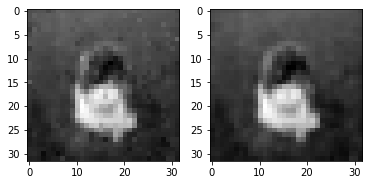

True label: 5
predicted label: 3
Time:  276.8095302581787  seconds
Initial fitness: 
 [-0.5790570257113626, -0.5861608731291283, -0.5916863033082079, -0.5857853689130482, -0.5858790536188206, -0.5827041922813998, -0.5777321575422065, -0.5912327253128702, -0.5835579230967264, -0.5916922229604424, -0.5845989007767285, -0.5845721957392961, -0.5832017002593811, -0.587238153017577, -0.5860417021126405, -0.582962237986741, -0.5867197771911621, -0.5876542123983904, -0.583303321693778, -0.5835199236865708, -0.5899785487999023, -0.5865962063109542, -0.5846631274934422, -0.5846491262299647, -0.5878751914432548, -0.583534955141987, -0.5836589109267892, -0.5825962890168007, -0.5897254820725104, -0.5782367424228114, -0.5857860974725119, -0.5871765887572136, -0.5834607673729664, -0.5882117148817951, -0.5769892656573414, -0.5880135823162898, -0.5871759382830362, -0.5871785702728329, -0.5932049201672869, -0.5857932571157847, -0.5863327942786829, -0.5857677475067993, -0.5868708805033128, -0.58642046874

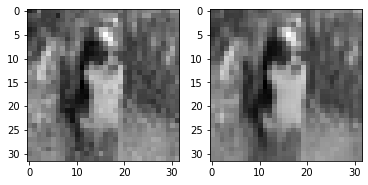

True label: 5
predicted label: 2
Time:  629.4624488353729  seconds
Initial fitness: 
 [-0.43412760398291644, -0.22084062087638012, -0.5065266043500839, -0.550727489408105, -0.34012522915779664, -0.48112712763749754, -0.4207229293475584, -0.45279440536520654, -0.439264042613911, -0.3440442425868509, -0.3947299168972961, -0.42804038895614804, -0.45848253750372414, -0.4564442807263266, -0.4363544351213733, -0.34590977237001364, -0.3661711268908989, -0.5380554441949995, -0.35257210026595887, -0.37996333636075275, -0.4204896294730569, -0.3899601138132427, -0.44789828634619966, -0.514920727456319, -0.4314439183683332, -0.39036615027997035, -0.4945570820331812, -0.4643574972991262, -0.42466359886094607, -0.4393875153664415, -0.4097570653766248, -0.4368656406797069, -0.5012908136964054, -0.4890289729061701, -0.42393433004857595, -0.42977188878555495, -0.4638392069998494, -0.4787570822018315, -0.5149685736406464, -0.33395192971801746, -0.3633549146970807, -0.499657981926273, -0.4747292474115486

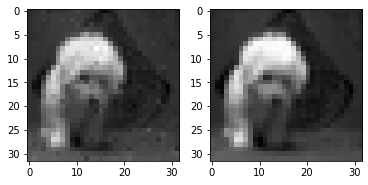

True label: 5
predicted label: 2
Time:  250.72708415985107  seconds
Initial fitness: 
 [-0.5821491695972938, -0.575184248701257, -0.5854720083099109, -0.5773135573982547, -0.529751733867383, -0.5876782686175167, -0.5818821719261993, -0.581302606299146, -0.5840332605664728, -0.5893616522827608, -0.5835987893440616, -0.5878866632494696, -0.5915358165121606, -0.5852429599271811, -0.579623662581585, -0.5847788217699756, -0.5899512799825738, -0.5805445001636779, -0.5832641992315862, -0.5767014114770057, -0.5888726361312258, -0.5750590473169639, -0.5821092417074211, -0.5751571126811993, -0.5853104200478185, -0.5811374052175877, -0.5782801999642503, -0.5832989464335523, -0.5851284834463549, -0.5890642722641046, -0.5891029825268492, -0.5861340141164948, -0.5842267252498886, -0.5844975469220691, -0.582394109009549, -0.5830584450926037, -0.5808181038568816, -0.5845859633948223, -0.5866852697505031, -0.5813338123518772, -0.584782125679575, -0.5855095098171302, -0.573691898007402, -0.5828788337505

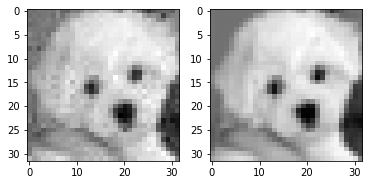

True label: 5
predicted label: 3
Time:  971.4228510856628  seconds
Initial fitness: 
 [0.1605592333123695, -0.2351381895777955, -0.060191788207140495, -0.09853893615796802, -0.014215105586650317, 0.3596506867448185, 0.25471253563991747, -0.19890121716091566, 0.13055328768539198, 0.20504638159144492, 0.17677901193366147, 0.2637007801555366, 0.01555013593435181, 0.15499257436479225, 0.19108071648179942, 0.14888759228223208, -0.014230374863769907, 0.23715781365996425, 0.13695809255156194, 0.08847865713123108, 0.11299407199978478, 0.1686882043707376, 0.21835411779249517, -0.03457954717348849, 0.26121305763212493, 0.043950314426891735, 0.044322996294164696, -0.17660676110833423, 0.1322662524164157, 0.08141752219193883, 0.1662089131915893, 0.19102877752822742, 0.11559037377859374, 0.18139829801579704, 0.142060637214451, -0.03839442095485454, 0.14225922825893395, 0.07719833743490415, 0.22104757822060309, 0.04272943360435319, 0.09523153813820794, -0.005139863457352789, 0.03794559244977422, 0.3

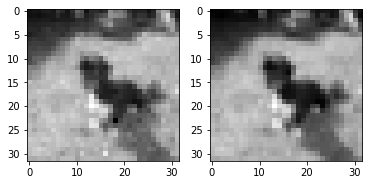

True label: 5
predicted label: 2
Time:  355.22769689559937  seconds
Initial fitness: 
 [-0.08869769989458198, -0.05544523105861304, -0.02893411808598223, -0.14883437995183826, -0.08526791400536227, -0.1460072818825082, 0.20892664123920765, -0.11688311847575283, -0.19404751223435807, -0.2737625966471803, -0.045573673739272375, -0.05417545702645604, 0.012543476320723806, -0.10303450156254626, -0.14672347381285714, -0.14657996778255653, -0.17724948306432367, -0.18702092782532187, -0.20833825309142023, -0.17087693432317072, -0.12788824963908163, -0.17608136528998805, -0.16861213494422808, -0.08497978299467004, 0.05269879589818707, 0.13176727244406744, -0.13321134868848264, -0.1055826016563407, -0.04644041860548523, -0.08085120662158818, -0.17107018199636498, -0.14321756983407452, -0.03165713036831741, -0.13476918565555318, -0.08243700458754483, -0.04594406908881846, -0.02691397039111898, -0.07443369480862047, -0.11863535309615839, -0.1471846950701031, -0.09532789830533148, -0.0510768488099

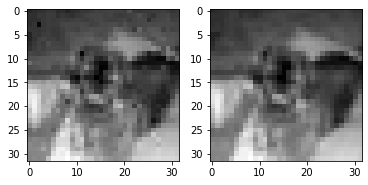

True label: 5
predicted label: 6
Time:  262.77013969421387  seconds
Initial fitness: 
 [-0.6012208700620533, -0.5996912811188777, -0.5995037386986364, -0.5989239304202829, -0.5982791050400883, -0.5997109475548192, -0.5987320562382368, -0.601905630191903, -0.6028650692823836, -0.5989838213017665, -0.5987199811528559, -0.5981838174020397, -0.5989399138007367, -0.6002446027929218, -0.5992217440941113, -0.5998023696500918, -0.5985050575070251, -0.5983089079047635, -0.5991274061889886, -0.5988464962878248, -0.5986755952565126, -0.5985105980914608, -0.5991117363035838, -0.5988103321263578, -0.5981934131541733, -0.59969452310318, -0.5997113797697458, -0.5992059698921909, -0.5995536245107045, -0.5985915340339137, -0.5985249300184396, -0.5983309178458776, -0.5986581440340106, -0.5987667339305351, -0.600614227960306, -0.5991476529444328, -0.5994534158747864, -0.5993501222744784, -0.5995864538722807, -0.59961337813864, -0.5983965028379125, -0.5988757803476978, -0.6002600651967214, -0.600942426346

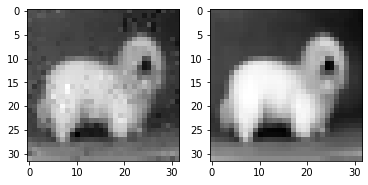

True label: 5
predicted label: 3
Time:  430.1630551815033  seconds
Initial fitness: 
 [0.7658000461993207, 0.7792440910402093, 0.7624384801115893, 0.7234219940541662, 0.7340144200867115, 0.757676040253184, 0.7356859300254418, 0.7512059098214742, 0.7244481434261953, 0.7128071894688446, 0.7614752241298287, 0.7184865735618184, 0.7451796604244757, 0.7237133756865085, 0.7388616259530171, 0.7811192054190519, 0.8152489665969289, 0.7494969154547436, 0.7168115315247566, 0.6896273556989284, 0.7813926183252922, 0.7106375333432686, 0.7220889624473561, 0.7023739715841951, 0.7308942287298161, 0.7012528922916067, 0.726245537732311, 0.7987042646024752, 0.7334219207043744, 0.7204923431732709, 0.749827644620859, 0.6221852582792374, 0.7400885367113754, 0.6790660470377197, 0.7410346884272148, 0.7350795227330446, 0.72257481480791, 0.8032839429223545, 0.75717386316087, 0.7365177234662328, 0.7323004878218043, 0.7712791381614917, 0.6902749962584709, 0.7469613857358379, 0.7252523846437935, 0.7413654623515399, 

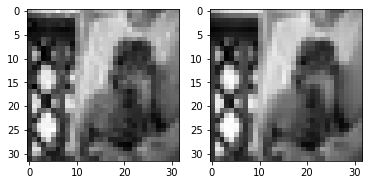

True label: 5
predicted label: 3
Time:  486.70249366760254  seconds
Initial fitness: 
 [-0.33757797878490226, -0.39104956840353133, -0.34595441168068497, -0.4081632270134249, -0.4009172187132105, -0.35221025677194245, -0.3650226084414343, -0.30916517397802845, -0.14222602288978864, -0.38928830547937343, -0.39285338062821495, -0.4051714504652193, -0.4236309584336308, -0.2995385175066324, -0.39920378979994553, -0.3541285086600842, -0.34367016078480284, -0.34120946072878666, -0.3737016997931951, -0.3536065166057589, -0.28005748261549157, -0.47317037235389814, -0.35121207910281416, -0.31507358092003235, -0.3387579790616797, -0.3252003684840047, -0.3518059408764481, -0.337788283928736, -0.37153797455182047, -0.3834174980504145, -0.25442320953469155, -0.3332980938708897, -0.28132550351091923, -0.4383742091454268, -0.2531816255590589, -0.3204981481535838, -0.36885138758959746, -0.40129197471458, -0.37535567590266466, -0.3674663277858595, -0.29297332548561805, -0.3371028693473659, -0.412889223

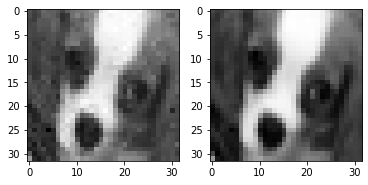

True label: 5
predicted label: 3
Time:  632.3618228435516  seconds
Initial fitness: 
 [0.176444497790686, 0.18064862283735394, 0.13539922156942047, 0.2132844072669656, 0.15888571787508066, 0.15073856708992367, 0.1944020787176729, 0.18594832524991897, 0.23128152448777922, 0.023827827301924065, 0.11507437942986767, 0.0845975068507104, 0.18230375802270468, 0.18895671475869444, 0.15269238306759408, 0.08009164287575452, 0.08259127134913576, 0.23190362612738422, 0.2204879571332959, 0.18955590436740014, 0.16117410330618373, 0.18148048569408431, 0.08829033543781739, 0.14505042941901547, 0.19260040316613822, 0.1301033323973258, 0.1712073443686481, 0.2604649351606886, 0.10187302716913488, 0.20522064102183396, 0.04920725518921659, 0.2085066756122129, 0.11968239401484541, 0.22672691834386038, 0.18136587692765768, 0.1637870644201599, 0.01737654465740876, 0.2830820019219322, 0.14267510918593695, 0.1666040259107071, 0.1469366504179066, 0.2054750095232974, 0.20110077078438554, 0.2022799100970391, 0.17

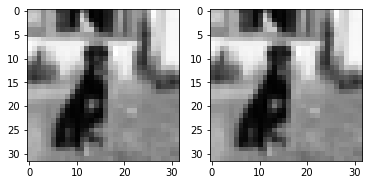

True label: 5
predicted label: 3
Time:  4.643829584121704  seconds
Initial fitness: 
 [0.41959292848430596, 0.5372676858072175, 0.5805815329243302, 0.46460739939552786, 0.5991888240572765, 0.5644209267561365, 0.37924952404835444, 0.6038615690584146, 0.6896074364633071, 0.5336717187058952, 0.6023678803256189, 0.5224027909661136, 0.5732992688662495, 0.58475569374168, 0.46962655874755366, 0.5919345632117607, 0.5519945968953603, 0.5865286812210347, 0.6255762452132994, 0.5214239125072369, 0.5808530387060113, 0.5997907034182517, 0.5594450399032309, 0.545144301510202, 0.5770711836165557, 0.557361329183248, 0.603337276628105, 0.5192208747456027, 0.5515750509341916, 0.5660301732423532, 0.46432061809980085, 0.5532996507722417, 0.5525465852569542, 0.6031289488332476, 0.5147786984337714, 0.3271245645591311, 0.6327331854310632, 0.520521260437041, 0.5750628815774823, 0.5851872316033331, 0.5289689475328065, 0.5266228700552783, 0.52816507131855, 0.6951196112960351, 0.5022524190539885, 0.60983002399741

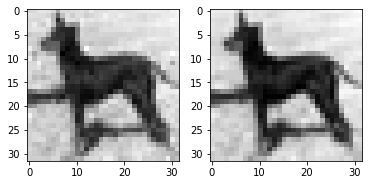

True label: 5
predicted label: 7
Time:  578.8052661418915  seconds
Initial fitness: 
 [-0.6003754016570049, -0.6000634826448139, -0.6005779338498384, -0.6000011352632041, -0.6004608102490855, -0.6000398497466686, -0.6002920529593999, -0.6002210479066358, -0.6000740756363256, -0.6000118264812105, -0.6001770077581824, -0.6003404398781543, -0.6000760706769547, -0.6000661641865555, -0.6000914986006678, -0.6004131804052973, -0.6000032994199487, -0.6005847731702045, -0.6000584751231985, -0.600529030631319, -0.6000078060791527, -0.6003029951979362, -0.6000843653104705, -0.600192117794037, -0.6002087797653581, -0.60015815481097, -0.6004687437653826, -0.6001637963525321, -0.6002474837240331, -0.6001873655231829, -0.6000249278856626, -0.6002630822200947, -0.6000084764039308, -0.6000895417512877, -0.6002969664908099, -0.600204405637884, -0.6000820010978971, -0.6002260118199699, -0.6001006198907267, -0.6001115058229037, -0.6000434653790763, -0.6005693913967076, -0.6001071140099872, -0.600049237361

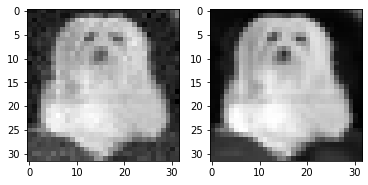

True label: 5
predicted label: 3
Time:  805.6323547363281  seconds
Initial fitness: 
 [0.5154068147907307, 0.15323470398133301, 0.17404640682679295, 0.2720119558679346, 0.234077300146896, 0.39384894489573913, 0.26486364653674166, 0.36512005454075175, 0.09762502874564966, 0.25964885790993025, 0.42229158975895303, 0.34674093390695465, 0.36204481057338356, 0.13882553439662648, 0.4016512609969158, 0.328193014366416, 0.308249112461747, 0.3761166499686751, 0.3194867707239248, 0.4630041456602555, 0.06840615054223928, 0.2536481938009787, 0.3077238005670921, 0.36066973131908286, 0.35004370568452425, 0.34455337661175, 0.33047481610378604, 0.28090487431289707, 0.31385070570520257, 0.3120576274144069, 0.3648188792299303, 0.391247878592717, 0.3641503378581515, 0.31594412904650493, 0.3179423374395094, 0.17464590121685278, 0.3456836492213712, 0.32882011251756843, 0.41961037355013164, 0.373515768395942, 0.31054013278819426, 0.266433649090059, 0.45480011619746186, 0.3735015810432183, 0.2533722082608275

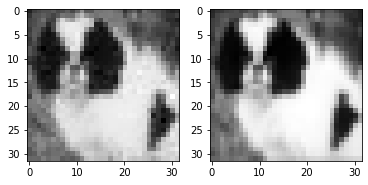

True label: 5
predicted label: 3
Time:  640.1515135765076  seconds
Initial fitness: 
 [0.3647208350275867, 0.37585097174180465, 0.5169128197399532, 0.4081093931546079, 0.32833781635506276, 0.4782417193414967, 0.4379989980971917, 0.34234652179100944, 0.20145728797201537, 0.4404537309354808, 0.2671793499651931, 0.34272954383765214, 0.36782612430428585, 0.42454293099897894, 0.2718437413622949, 0.13027639545893077, 0.4327062488019523, 0.2660121281920511, 0.47240830848610216, 0.5073719324942438, 0.4238159867529279, 0.46624287951456317, 0.6253078663501653, 0.3340116328329211, 0.40361413663956625, 0.4186979286805635, 0.550743548424808, 0.3799692157572554, 0.3824255585656462, 0.5190517930311701, 0.34571124784238977, 0.4810185200466077, 0.6510761018920648, 0.4375656223358889, 0.3798109399927797, 0.37217982156778395, 0.2739400486355239, 0.45733710285141266, 0.42075316114628625, 0.3759371641511755, 0.32424356574644053, 0.4345235833887964, 0.4477460121155845, 0.46825742744500004, 0.158488004918088

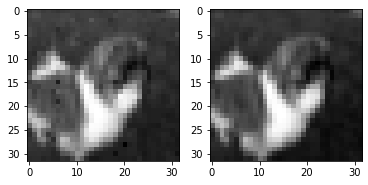

True label: 5
predicted label: 3
Time:  176.0257534980774  seconds
Initial fitness: 
 [-0.6003024230737233, -0.6003406644800049, -0.6002441292565864, -0.6002479781763806, -0.600096899145876, -0.6005524510162414, -0.600377685590793, -0.600289348613763, -0.600043900883141, -0.600245665298791, -0.5999984483387958, -0.6006714593590446, -0.6002504435125583, -0.6001538157645154, -0.6001355741711645, -0.6002274294339701, -0.6005248485467568, -0.6005910957653672, -0.6000909925404302, -0.6001541773029906, -0.6003163667336402, -0.6007726860774923, -0.6003780109391947, -0.6001319409746928, -0.6000497079055804, -0.600136582115035, -0.6002021226064507, -0.6002318853449387, -0.6004769269590139, -0.600081519137819, -0.6001866461171919, -0.6001201428890434, -0.6002641760805075, -0.6002082118918567, -0.60025674552327, -0.6003578750981223, -0.6000707600515401, -0.6003073001160454, -0.6001589244679555, -0.6000811354135631, -0.6001494552379869, -0.6002670738835805, -0.6001541686248832, -0.6004921408674484

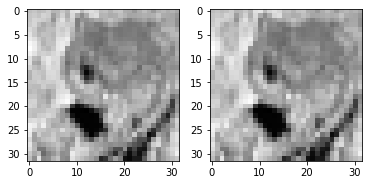

True label: 6
predicted label: 6
Time:  128.48468160629272  seconds
Initial fitness: 
 [-0.5621737683639629, -0.5465713601462964, -0.577417336161817, -0.5578458523615224, -0.5414763974401153, -0.5226744318486762, -0.5521448165367584, -0.5616910466274496, -0.49558547346470605, -0.5446987873351922, -0.5540217077871804, -0.5171451657590368, -0.5621256744470835, -0.5551780137728587, -0.5633233811768474, -0.5730252748586657, -0.5459895087669449, -0.5615452320550164, -0.5501167522007169, -0.5529068164868692, -0.5414935963016609, -0.5376729383554539, -0.5460144646875758, -0.5506940569713115, -0.5324601489870874, -0.5588278535291432, -0.5470775891207276, -0.5548316370555596, -0.566079688381924, -0.5408154471716862, -0.5652412276451518, -0.5633312935671334, -0.5473688766377054, -0.5437353552538076, -0.5222013510316026, -0.5437612832680955, -0.554294805185038, -0.5457399829727507, -0.5510979529276947, -0.5630643779899123, -0.5702540368145109, -0.55532763755946, -0.539313087157085, -0.52577245161

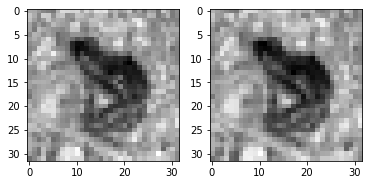

True label: 6
predicted label: 2
Time:  410.56533217430115  seconds
Initial fitness: 
 [0.6444640306119958, 0.46946831013618506, 0.619643382359748, 0.4839785081929649, 0.5588510292990807, 0.6564682140415332, 0.551933675272614, 0.5512829089236388, 0.6241063532669684, 0.5294426645377064, 0.531996724627299, 0.5218732671410159, 0.5783958322871499, 0.6209124294323323, 0.6240141362366357, 0.5846410242439601, 0.525632070135849, 0.5998991608999242, 0.561929180654444, 0.5740697050108469, 0.7082612991030034, 0.587236039049715, 0.5757943397991134, 0.6488487826179327, 0.552593980376072, 0.6115576261797684, 0.6622820927544161, 0.576350655530018, 0.640771234820678, 0.5347686064856106, 0.505872252474844, 0.5141579533366586, 0.519458036416213, 0.6284469523157548, 0.5488275375631497, 0.746860430581024, 0.5648902439793669, 0.5774226583451365, 0.5656880529765399, 0.5086375171878317, 0.507609430783715, 0.7013734858573564, 0.711427249258257, 0.5988547537621919, 0.5226937828281351, 0.5841056549698753, 0.521

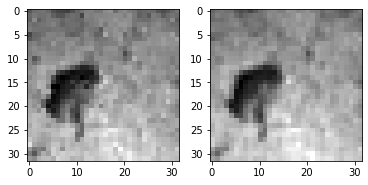

True label: 6
predicted label: 2
Time:  203.52605891227722  seconds
Initial fitness: 
 [-0.5999456332665489, -0.6000369725314264, -0.5998149156746632, -0.5997331901310741, -0.5996100107777831, -0.5998141679801294, -0.5997705370008976, -0.5994080624965867, -0.5996441899107117, -0.6000690749630008, -0.5997219688069637, -0.5995873552438407, -0.5995893139031536, -0.5997387463270971, -0.5994856961963073, -0.6002214499370842, -0.5995014751762704, -0.5998164107134687, -0.600024570635486, -0.5995675704129586, -0.5996179691128154, -0.5994888893251714, -0.5996102327772532, -0.5997057188495499, -0.5995378891850558, -0.5994280385161547, -0.5994314149968907, -0.5994604489718228, -0.5997305096426953, -0.5996328686002753, -0.599617084660564, -0.5997498695147707, -0.5995609546370452, -0.5996064742408093, -0.5998560643142404, -0.5995168669043421, -0.5999483646898616, -0.5997345153007655, -0.5996552987240866, -0.5998815262069808, -0.5996952780538314, -0.5994047794467496, -0.5996349475421339, -0.59953939

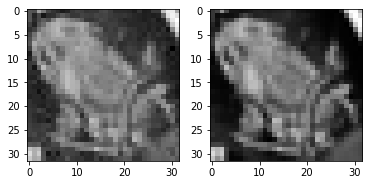

True label: 6
predicted label: 2
Time:  917.8843758106232  seconds
Initial fitness: 
 [-0.61135798675485, -0.5991282477045378, -0.5975431807945996, -0.6005489227682441, -0.5998900363925823, -0.6024163801743255, -0.5990073683045329, -0.6013410796644983, -0.6039205430832092, -0.5986355229038485, -0.6046561320152206, -0.5967217126362512, -0.6062894827375851, -0.5977918149510951, -0.604586216695071, -0.6056172732552977, -0.5979649821915518, -0.6035172014155155, -0.6013367940167423, -0.6009736922305866, -0.6047744293805788, -0.6035268809230783, -0.5986474570841445, -0.5992788233158872, -0.6054399600763295, -0.6012710062326645, -0.5969825085623355, -0.6028051584064348, -0.6072720614559257, -0.6020452629043829, -0.6026155145868429, -0.5980777572899416, -0.6026891730991643, -0.6015146764084711, -0.5985141275085838, -0.602504745180257, -0.6023757846732051, -0.606931551731758, -0.603650750173545, -0.6048946581965274, -0.6053801997067432, -0.5977035789400148, -0.6061733879706492, -0.6079064967829

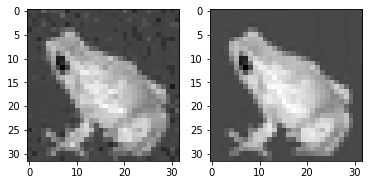

True label: 6
predicted label: 2
Time:  316.41639947891235  seconds
Initial fitness: 
 [-0.42965873447617253, -0.49720349807466657, -0.48239213555194227, -0.4913353632001658, -0.472101081597628, -0.5134402468245165, -0.5172638174335176, -0.40980049524464557, -0.4920120315968971, -0.4863525691425446, -0.5064124253284703, -0.5468204196253523, -0.46115335370409927, -0.46400625445024124, -0.5180553746949492, -0.492870001800232, -0.500207953320547, -0.4672428105205124, -0.48959476593511764, -0.503989145760768, -0.5030798444369728, -0.4907181813374578, -0.532339548244638, -0.4849413451086052, -0.5150738363419723, -0.4684829711788774, -0.4948529983579837, -0.47533752853626465, -0.5278244733928396, -0.5492650627786483, -0.47469448083951143, -0.4798192731699197, -0.490489907077291, -0.5356864010525684, -0.48977488481082554, -0.4572358896923937, -0.4480800969266997, -0.4943968374621032, -0.5373122961272827, -0.5414880488491361, -0.5175526899117103, -0.5045418539831183, -0.5390497706025302, -0.48

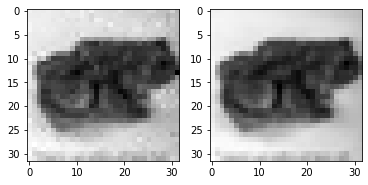

True label: 6
predicted label: 3
Time:  452.99206352233887  seconds
Initial fitness: 
 [-0.5991611520362505, -0.5992035497309901, -0.5990388800055781, -0.598744274717891, -0.5993685311709094, -0.599215912614876, -0.5991658872409844, -0.5992687875436837, -0.5992576207899758, -0.5991772220083463, -0.5990386486498828, -0.599294241878416, -0.5992181177949868, -0.5990717974220745, -0.5981547071145601, -0.5984999735282417, -0.5998249753674189, -0.5991407119114434, -0.5993484089421435, -0.5989890751642879, -0.5994197327897175, -0.5993548367148273, -0.5987872668902771, -0.5993486814961205, -0.5991901648090424, -0.5991353225643286, -0.599405140071455, -0.5992715183113562, -0.597700324710824, -0.599478871072761, -0.5992850601436324, -0.5990782316829278, -0.5989942832987246, -0.5997669518902606, -0.5991269953096666, -0.5996329393668924, -0.59938171429423, -0.5995280367344904, -0.5990257806253854, -0.5992757926929593, -0.5988696289561335, -0.5987452856010858, -0.5994130451901931, -0.59915139795413

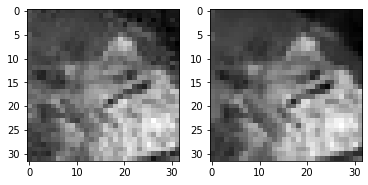

True label: 6
predicted label: 2
Time:  680.9967589378357  seconds
Initial fitness: 
 [-0.2891591855243335, 0.017657837160678952, -0.192963361059826, -0.11597081428387032, -0.03548714471240019, -0.009407685338355093, 0.07800140355003651, -0.16958383844404695, -0.164836749970467, 0.14084741119349525, -0.02013636711809791, -0.3543179418597645, 0.12763020519792023, -0.10383303237768185, -0.039105210040075916, -0.21915078884014835, -0.08853959351221816, 0.12208821169007338, -0.18085242732207152, -0.07453215690736695, -0.1347833491439739, -0.08706236813392887, -0.00657139783073124, -0.22945135083707324, -0.05550040435168116, -0.14980780854806514, -0.14246175045134218, -0.03244331196494388, -0.04489611587623443, 0.1312726020568596, -0.2220595674247586, -0.0482946940292758, -0.04656659861915877, -0.13420593274715012, -0.3357592894343734, -0.11872373795121005, 0.08833715725868435, -0.13729664326501798, -0.128899032699803, -0.022765237703862462, -0.19663144236201274, -0.12991538109537393, -0.17

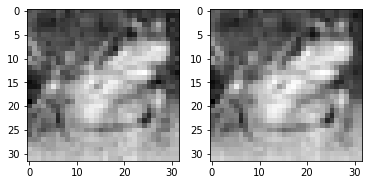

True label: 6
predicted label: 4
Time:  375.8215982913971  seconds
Initial fitness: 
 [-0.5996200318931098, -0.5999130125066794, -0.5998798733331863, -0.5999590127317447, -0.5997879095499065, -0.5999326032973414, -0.5998421542107718, -0.6002180134215687, -0.5998175518801747, -0.599798661099613, -0.5999344937649034, -0.5999816812918557, -0.5999813210967269, -0.5998346695446609, -0.5997671063332678, -0.600190297924269, -0.5992533367783965, -0.5998217632477403, -0.5998086725266816, -0.600037346242875, -0.6000140326070098, -0.599845459167805, -0.5999795815258985, -0.5999030374100325, -0.5998767959191305, -0.5998904889838035, -0.5999687571552113, -0.5998200048743793, -0.5999556028629653, -0.6003458946401428, -0.5999539020839468, -0.5997383719476828, -0.5998541168976648, -0.5997623857542099, -0.5999708246843748, -0.5997255005323971, -0.5998955224854297, -0.5998373772248996, -0.5999020673757609, -0.6000086728532169, -0.5997401012879784, -0.5997664794464839, -0.5997447111533631, -0.59999271294

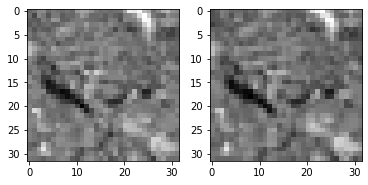

True label: 6
predicted label: 2
Time:  629.2440841197968  seconds
Initial fitness: 
 [-0.5870085533095567, -0.5906999095410636, -0.5955452186392844, -0.5883207976884886, -0.5889828732597187, -0.5910033395659899, -0.5891837083185064, -0.5957760877944663, -0.5879956127441707, -0.5913662278130662, -0.5951387716186662, -0.5903920593253293, -0.5850989701388357, -0.5940026320430573, -0.5864762572295255, -0.5898001057974379, -0.5912573444765715, -0.5869945088444021, -0.5831584542319157, -0.5910361282034455, -0.5940193174222214, -0.5857655726347245, -0.5881931882369813, -0.5883187742793756, -0.5836598140939699, -0.5863185356569235, -0.591915985562282, -0.5871295821751008, -0.5835720973683729, -0.5919119516318366, -0.5962502983120124, -0.596205671035529, -0.5839828581925244, -0.5890220524877674, -0.5845232655042731, -0.5908183538668644, -0.592358667073396, -0.5948320537536432, -0.5861152922913039, -0.58466125480593, -0.593874365457115, -0.5866518538675118, -0.587449226874821, -0.59243671018759

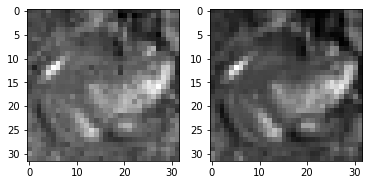

True label: 6
predicted label: 3
Time:  339.0518910884857  seconds
Initial fitness: 
 [-0.5984975410960552, -0.5987257301871535, -0.5983610054742999, -0.5977198241237676, -0.5967507063892494, -0.5979465571498288, -0.5973184274350585, -0.5980681173834601, -0.5977749756367862, -0.598140198664208, -0.5974797202527762, -0.5975658078537381, -0.5981559091858099, -0.5977173551123786, -0.5980735314662767, -0.59834054036805, -0.5980960159888622, -0.5975084533103433, -0.5973550843710206, -0.5975069951302947, -0.5974776156370445, -0.5969526794662148, -0.5980328861269542, -0.5976450123464874, -0.5968756877986859, -0.5973248008652201, -0.5984251118467521, -0.5972985984864098, -0.5983014921206158, -0.59771773859515, -0.5976450497721301, -0.5975319363507171, -0.5975760999540325, -0.5970503232110176, -0.5986385419620529, -0.5981186612685075, -0.5982612047433951, -0.5972492715514934, -0.5978230510231131, -0.5978220082519647, -0.5979027049194112, -0.598051292476512, -0.5979605363459515, -0.5981278811125

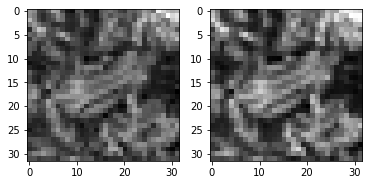

True label: 6
predicted label: 2
Time:  748.7408182621002  seconds
Initial fitness: 
 [-0.5951699202437052, -0.5980360520665058, -0.5984533295170134, -0.5958401343599238, -0.596250822581957, -0.5971363462915402, -0.5943979625667609, -0.5955441841086925, -0.5949839953723381, -0.5955705879496327, -0.5954948018917734, -0.5951507838268136, -0.5949182266735142, -0.5957245959308686, -0.5967881482339413, -0.5983940876626853, -0.5954433198423977, -0.5984907251191085, -0.5953603988603842, -0.5953553051236707, -0.5955960682248957, -0.5960543287381334, -0.5954123218822946, -0.5971359722552121, -0.5958657131256664, -0.5957256445243146, -0.5973935098746577, -0.5950041517438526, -0.5977138514876166, -0.5960193243744973, -0.5942507785088886, -0.5965208372713199, -0.5967278016759635, -0.5947765027748001, -0.5977537451953256, -0.5959653821784321, -0.596198650054897, -0.5939610362676961, -0.5962939935709052, -0.5945593958744139, -0.5955677097415245, -0.5979949852898258, -0.5977251473978913, -0.598481437

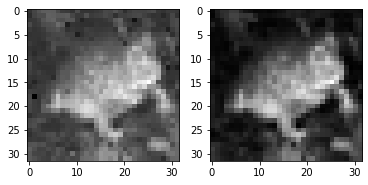

True label: 6
predicted label: 2
Time:  209.23416900634766  seconds
Initial fitness: 
 [-0.5982102609801289, -0.597819008874602, -0.5982875864161072, -0.5970514545699341, -0.5978565540101636, -0.5982939332827076, -0.5973997255108976, -0.5972476331402614, -0.598243788422075, -0.5985367870241722, -0.5984829597450879, -0.5964119601563934, -0.5985031464021147, -0.59766591498619, -0.598118575450328, -0.597952377870385, -0.5981667185523445, -0.5966512430752726, -0.5980185206411969, -0.5982263807256912, -0.5979044445041359, -0.5988696672330767, -0.5985771327120348, -0.5994551510588858, -0.5980543507932128, -0.5990762443046374, -0.598327781679262, -0.595904391260116, -0.5984181753814295, -0.5978941211488219, -0.5987254188963851, -0.5975291786632873, -0.5979542007910199, -0.5984947338756744, -0.5988254836427818, -0.5973814981769137, -0.5974155351215037, -0.5987732225187916, -0.5987276182568885, -0.5977328839430706, -0.5984924466877364, -0.597946533080625, -0.5990998036735607, -0.597461014287811

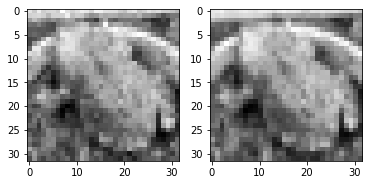

True label: 6
predicted label: 2
Time:  767.775842666626  seconds
Initial fitness: 
 [-0.5993144057555625, -0.6015430016164933, -0.6012883505635348, -0.6019002960362294, -0.5990533502115907, -0.5991949479810076, -0.6012096731837917, -0.6004729577698524, -0.6004293805645836, -0.5992768751297971, -0.6017331573453564, -0.6020713769130801, -0.6021062659341395, -0.6021329688268717, -0.6019524514951, -0.6009441520421769, -0.6017146905144349, -0.6005774856932952, -0.5993072513328636, -0.6010549449816819, -0.5997319831446881, -0.5993680841086205, -0.5999714485897502, -0.6011488056822596, -0.6013379998252784, -0.6024101902165787, -0.5990878308435349, -0.6015741986056203, -0.6015395829008688, -0.5996363643143157, -0.6013262163269631, -0.5994114727155454, -0.5993164283192158, -0.6001027610679794, -0.5991335702225145, -0.6022555484751221, -0.5993458066607437, -0.5996644296701966, -0.6014471959554646, -0.5998538271917078, -0.6012702434320991, -0.6002437452938225, -0.5991784421163329, -0.60263595699

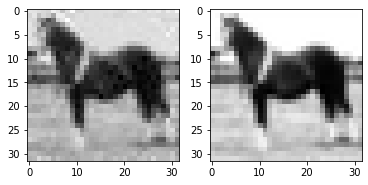

True label: 7
predicted label: 5
Time:  1064.614453792572  seconds
Initial fitness: 
 [-0.5972091322521983, -0.6025988716039486, -0.6058503848415173, -0.6006803631407084, -0.601182896852676, -0.6019280403009155, -0.6018844027369342, -0.5991589612927077, -0.5996173874621127, -0.5990577477595578, -0.5997323884399002, -0.6012458574440711, -0.6023109128124824, -0.601859304277176, -0.5990696066197825, -0.6001143442558594, -0.6013178135808909, -0.6019309748253594, -0.6018090778179996, -0.5993678795072179, -0.6028575159540221, -0.6021511649632562, -0.6042345715409976, -0.5985406958229336, -0.60199296573889, -0.5994712667552654, -0.6014211945012035, -0.6035530334713423, -0.6024192959229617, -0.5987238345218985, -0.605797788574882, -0.6049433344181231, -0.599738718576963, -0.6005983151464034, -0.6012910882751722, -0.5988420298011283, -0.6037749229312922, -0.6012770482867104, -0.6022290919698683, -0.5994101574314818, -0.6000957678008696, -0.6071810234739695, -0.6000137752965788, -0.6047831145062

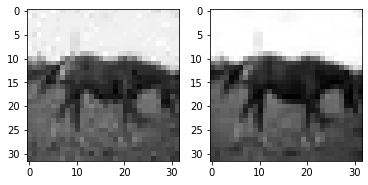

True label: 7
predicted label: 4
Time:  395.6182293891907  seconds
Initial fitness: 
 [-0.6029400284776677, -0.5998435482439786, -0.5997594065775154, -0.6001557618495866, -0.5999814804946355, -0.5999968254634047, -0.5996709643445366, -0.6000613878249331, -0.6013455022114418, -0.6001295002876335, -0.6002636606492828, -0.6001068053152475, -0.5999186002305913, -0.600897073674357, -0.6001596733795093, -0.6002087444247654, -0.5997097465649102, -0.5996758180340989, -0.5997625809357443, -0.6013925321183268, -0.599802276595978, -0.5998952600764881, -0.6010155380854452, -0.600096797952882, -0.602133432998254, -0.5998591533774171, -0.5996833288678662, -0.60080193120521, -0.599805855391859, -0.6009640935820679, -0.5997466586960797, -0.5999827465415678, -0.5996528685547022, -0.600202867354838, -0.5998130995136135, -0.5998554675630194, -0.5999171095892197, -0.5994221821956851, -0.6013010844308837, -0.5997395911946632, -0.6000885144624174, -0.6001321748713784, -0.598824981262283, -0.5999935234845329

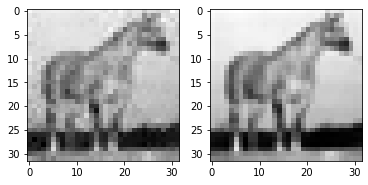

True label: 7
predicted label: 6
Time:  511.6359450817108  seconds
Initial fitness: 
 [-0.5123696172746581, -0.53812143848587, -0.4565549273224466, -0.5379277758674774, -0.5160264353081847, -0.5446120788088151, -0.5335650663556089, -0.5284505309168892, -0.5158553779744736, -0.5174850354943011, -0.49973604203137556, -0.528117917763235, -0.5212061085854653, -0.5119069848239579, -0.5290645902778639, -0.5342474474739635, -0.5017182161046165, -0.5252374910564417, -0.5474634624534676, -0.33993095424364395, -0.5351056219174198, -0.42513739272528817, -0.5605590466468752, -0.49845045303434204, -0.5340703506061517, -0.5512925385600566, -0.5003552012593269, -0.5146534657467341, -0.5177241582037357, -0.5148707956039289, -0.5493817683229193, -0.5329663377117616, -0.5404189770455663, -0.5679618608913766, -0.5176759476611514, -0.5422245928486631, -0.5361075429014217, -0.5276479306472127, -0.5285169205653752, -0.40828414139131897, -0.5549381935019111, -0.5020663008481802, -0.523185516188778, -0.518008

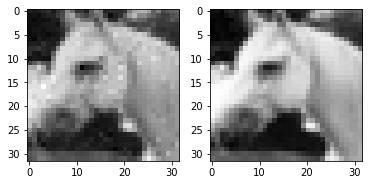

True label: 7
predicted label: 3
Time:  347.8462977409363  seconds
Initial fitness: 
 [-0.5042250034247185, -0.4936427356377303, -0.5231259207909462, -0.3879043664166748, -0.48534379691483054, -0.48356140632488825, -0.46460135549431897, -0.2946051212701117, -0.5113727247618739, -0.4529101027576903, -0.47781981192180845, -0.47829216474879876, -0.42472619379389354, -0.5069558300799585, -0.5002345180283063, -0.5042019447415413, -0.47565927880703396, -0.456965781313295, -0.48996866042045817, -0.3441750808746388, -0.4458168858717755, -0.5082872616768279, -0.43151246736125337, -0.5024871955520162, -0.5044549050531849, -0.473209727282321, -0.5151496295658317, -0.5341692188715387, -0.4939917388433793, -0.4111694681559923, -0.47240829908579673, -0.4915848146547119, -0.44940446074326634, -0.48835968735272084, -0.4930361171464329, -0.5165935177164935, -0.4987980479177347, -0.49970102943080447, -0.41864122365271716, -0.470497746410714, -0.49225396616141504, -0.5166064047566524, -0.5111395278575707

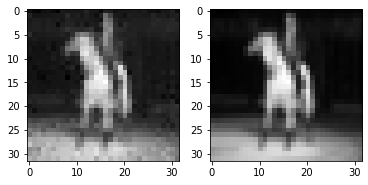

True label: 7
predicted label: 5
Time:  517.6744813919067  seconds
Initial fitness: 
 [-0.6001702018486268, -0.6000642691908974, -0.6010889694695924, -0.6001925783200459, -0.6003085777847815, -0.6011412622422921, -0.6001681509821576, -0.6004463644821044, -0.6003399163016534, -0.6001919345535308, -0.6000959057426978, -0.6002060069405973, -0.6005191991024471, -0.6001217125459011, -0.6001165545902512, -0.6002486487872163, -0.6005172010390031, -0.602257167634095, -0.6000968931472007, -0.600472452126384, -0.6013047883386562, -0.6003700235064535, -0.6003742863284833, -0.6001775270545672, -0.6004154063244624, -0.6002305149044621, -0.6002140569036247, -0.6006764312915769, -0.6005939200820207, -0.6016811890965699, -0.6002097570794185, -0.6004909466807902, -0.6004392017457159, -0.6002064493675929, -0.6004298962110359, -0.6003725719215965, -0.6006285504275028, -0.6000164246404831, -0.6000866979691022, -0.6004565133782316, -0.6011686191748846, -0.600126627442962, -0.5999947529395466, -0.6007053567

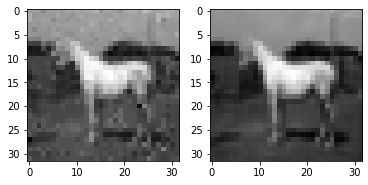

True label: 7
predicted label: 5
Time:  393.1308994293213  seconds
Initial fitness: 
 [0.5355466405815247, 0.609514116703405, 0.5337156428742182, 0.6165431053663174, 0.614927018238325, 0.5888646180387089, 0.6699676720575787, 0.5359183872096444, 0.5689918509830085, 0.5340189123268022, 0.5503480370132907, 0.5821829244427821, 0.5893396167056868, 0.6140807382022571, 0.5681636725912271, 0.619861313728703, 0.6363573253138569, 0.5649327581099581, 0.5562321935191403, 0.5748595059906205, 0.5488547527316698, 0.5473057784770838, 0.5580120822362017, 0.5868577194478305, 0.6763154769030597, 0.5790587139345829, 0.6037838989668766, 0.6216288517344419, 0.6295222106368445, 0.6344166476438166, 0.5664308770489267, 0.5626167604454011, 0.5967308230013616, 0.6312212088928395, 0.5811970664701334, 0.5485351283221249, 0.6230412179082596, 0.654631333633832, 0.6085386931444137, 0.5700159692190891, 0.5781280100112416, 0.6264318526478191, 0.5733158300586108, 0.5650124268079424, 0.6596615878584831, 0.529593164379015

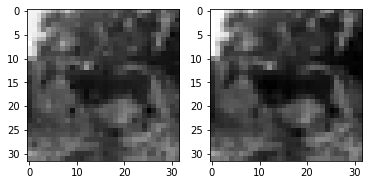

True label: 7
predicted label: 4
Time:  189.52168369293213  seconds
Initial fitness: 
 [0.4773125251016722, 0.256249769977334, 0.342553197877405, 0.346954354176378, 0.3277159593093549, 0.3220392008184913, 0.19939662791159113, 0.324853586072865, 0.4118652559869922, 0.45129846651734795, 0.3040031927496384, 0.20036737246156597, 0.524922140403443, 0.27082111526801445, 0.2104838380437229, 0.48545158674377703, 0.31823221374036936, 0.2981295638443091, 0.3108857811484255, 0.29688245360859083, 0.3897778027302042, 0.3428834370372, 0.42727087868611746, 0.3616033936465034, 0.44887257602147784, 0.39128108917219157, 0.37456009513391547, 0.25838089270349957, 0.213630353303779, 0.39820824322407394, 0.3476026119753124, 0.27599476288873964, 0.29822491418167346, 0.22523086356925154, 0.41955373574087496, 0.24918894056831523, 0.41333452117154856, 0.37355691387017737, 0.3594162438459398, 0.15645513589583238, 0.3104133086756321, 0.3174960333551347, 0.4098985323740776, 0.4484483926288556, 0.30865382708870137,

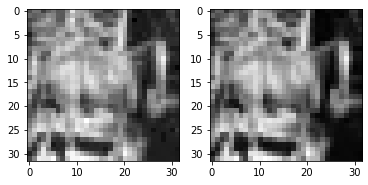

True label: 7
predicted label: 9
Time:  211.9583442211151  seconds
Initial fitness: 
 [0.29794511056293743, 0.24376727299244194, 0.2940834521384111, 0.3464000598553953, 0.2345965760122724, 0.24693598201050185, 0.37845362549552664, 0.2204637813948053, 0.22142906406884644, 0.3027411471329911, 0.1841908127095046, 0.06432139824965907, 0.2926201799209557, 0.132110541904858, 0.13578365340558013, 0.24519199614723156, 0.3878194423528474, 0.2345679503069276, 0.336453837155851, 0.12100569523859848, 0.3403190779997994, 0.02573371199033153, 0.45412949143881615, 0.18781611643527657, 0.2801313323125518, 0.4845456355727035, 0.1752007138407749, 0.20198328417749795, 0.20811286883050992, 0.4491650329179888, -0.03743083670935532, 0.22481565636062736, 0.4821161764526619, 0.29116463742623766, 0.313649916057569, 0.3179099057470085, 0.32712909262631307, 0.23879709728786674, 0.42427114473498295, 0.3413621008056273, 0.40042373669617676, 0.28430985464747954, -0.12084989423916576, 0.164587743758109, 0.3560549515

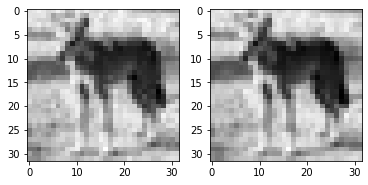

True label: 7
predicted label: 4
Time:  265.8179099559784  seconds
Initial fitness: 
 [-0.5694368931116615, -0.5676388148119514, -0.5772740008300795, -0.5813438688951754, -0.5748894870584638, -0.5895390589110585, -0.5753045442841902, -0.5728938258706554, -0.5750767654382, -0.5792042898451132, -0.5803597056351337, -0.5817698398048917, -0.5830684775067766, -0.5833234325941148, -0.5709139449775529, -0.5739233658123432, -0.5748352240871255, -0.5775960843491583, -0.5777771105253128, -0.5760227837024878, -0.5818501938431753, -0.5729040353865615, -0.5833876276350327, -0.5855039759498148, -0.5809943544907894, -0.5800287766326747, -0.5882360823798424, -0.549776438480552, -0.5687597147756245, -0.572350596807051, -0.5763306039441685, -0.5830975208555267, -0.5724633813909107, -0.5744817047986788, -0.569987871774589, -0.5810360046257302, -0.5806305023588212, -0.5822259162208698, -0.5596142776461134, -0.5783368777990656, -0.5835516629797083, -0.5766664231274932, -0.5791025702577509, -0.5796154508890

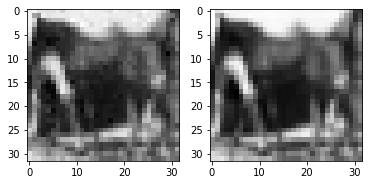

True label: 7
predicted label: 6
Time:  357.41869854927063  seconds
Initial fitness: 
 [-0.5968993097165439, -0.5964205811396948, -0.5955048548527844, -0.597392017450299, -0.5956968289644468, -0.5985171613307653, -0.5921341428897549, -0.5969175397549338, -0.5970883974809658, -0.5961214458683178, -0.5958728434629567, -0.5969538400541614, -0.5968134422851462, -0.597261160005863, -0.594134556933055, -0.5963208424111898, -0.5972947199260803, -0.5932109765488889, -0.5974603411718311, -0.5973854721926555, -0.5947275406080066, -0.5969777570567695, -0.5957839858290314, -0.5917535522460353, -0.5970582977527598, -0.5977831565456634, -0.5972102546826685, -0.5970844275767386, -0.5976487115781979, -0.5980979109642469, -0.5977551711974236, -0.5930939111555974, -0.5957242708509317, -0.5968237525956515, -0.5932816556496692, -0.5969105147763802, -0.5974049701508665, -0.5969610893103499, -0.59654966332836, -0.5956667305225367, -0.593280558018742, -0.5982013282132508, -0.5986671209104072, -0.597660605541

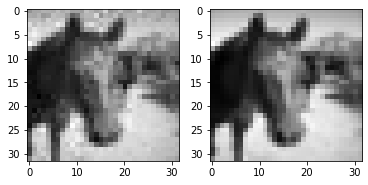

True label: 7
predicted label: 3
Time:  524.9342515468597  seconds
Initial fitness: 
 [-0.5853127486126353, -0.5881172256226953, -0.5890837909855894, -0.5876871615667648, -0.5865771463158312, -0.5793330806989365, -0.5876318085406065, -0.5917668910731076, -0.5877054463206368, -0.5661985487435581, -0.5919692227036973, -0.5913601749059719, -0.5846528990515033, -0.5852565746554409, -0.5894815252366228, -0.5883671679197882, -0.578634711021629, -0.591440483378164, -0.5866912922584668, -0.5890839053040913, -0.5898780395656684, -0.5894187659690391, -0.5915742605829908, -0.5868093237390837, -0.5897471032322628, -0.5864518932624229, -0.5864255527345188, -0.5920513274258088, -0.5735007402263181, -0.5867899759533356, -0.5884471948758098, -0.5882092662976899, -0.5918235707935133, -0.5892942618673553, -0.5807474566253235, -0.5889749835268749, -0.5850044434819579, -0.5894571281771627, -0.5859726298631144, -0.5862672424035562, -0.5929544769787066, -0.5871111287899814, -0.5925391870793597, -0.590261006

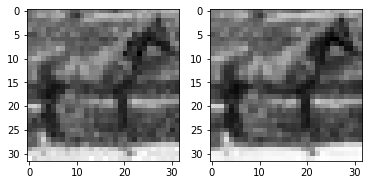

True label: 7
predicted label: 4
Time:  415.8454399108887  seconds
Initial fitness: 
 [-0.3269870131168844, -0.22547798112040524, -0.18872378777137627, -0.1363402705030924, -0.4019342643304542, -0.14285844504936607, -0.44227813316777176, -0.3786589636360177, -0.4167850708363721, -0.4252670783500915, -0.3773018760129704, -0.193063377576594, -0.2978144506586145, -0.2033335485517277, -0.2710258690305691, -0.3536253975540851, -0.31293313117198296, -0.3079438885345793, -0.1713891783679077, -0.2557078080579128, -0.22723288358217245, -0.27617618527086085, -0.24618934265269798, -0.27671303069453496, -0.2675906020682456, -0.083331435946533, -0.18848580569766224, -0.32742289308914774, -0.4086166121781786, -0.334466598875497, -0.34067189567132816, -0.24078131559084628, -0.2744590489414513, -0.2230415809499598, -0.2682884766325392, -0.2568627758248062, -0.20454161642463242, -0.22265537904620752, -0.24184305740830248, -0.33857235950674225, -0.1922968190766726, -0.15554714989670032, -0.1296425164119

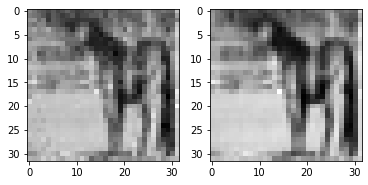

True label: 7
predicted label: 4
Time:  467.1901035308838  seconds
Initial fitness: 
 [-0.5996304272957339, -0.5994424594346698, -0.5994163364423488, -0.5994648151465215, -0.5995154850398792, -0.5998837621882206, -0.5993147590228222, -0.5996424553396689, -0.600342701483808, -0.5990995533083108, -0.5999014407680385, -0.599988230219778, -0.5993495534870804, -0.5996377499628341, -0.5997645822276725, -0.5989329943456504, -0.5993529306402253, -0.6002649479561343, -0.5995885565731922, -0.5995350554976889, -0.5992094809418312, -0.5996365741346038, -0.599339186779185, -0.5999678379552591, -0.598242201210005, -0.5998011893386976, -0.5987195310361736, -0.5995504301722101, -0.5997623462207473, -0.5994620411513648, -0.5991026585613574, -0.5994707057361738, -0.5993474932223357, -0.5992933151865, -0.6001853941760844, -0.599158875592448, -0.599527195561709, -0.5998442475048489, -0.5994936738642831, -0.6003377082446778, -0.5997029081487859, -0.6000721290859311, -0.5993509431351332, -0.5993540599983348

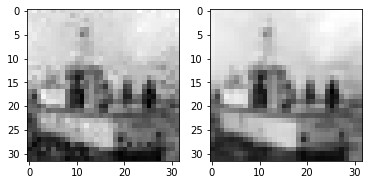

True label: 8
predicted label: 9
Time:  585.6039228439331  seconds
Initial fitness: 
 [-0.5718788659343986, -0.5608661739139331, -0.5808536772436518, -0.579730726165492, -0.5713730776266556, -0.5717694298099752, -0.5720292768591306, -0.5796497386442545, -0.5713939526556322, -0.5604902792680543, -0.5713233398295886, -0.5486680285633794, -0.5292443597144962, -0.5748005343453817, -0.5719112188524574, -0.5645870524438197, -0.5753063058419273, -0.5772953525551919, -0.5764469083002125, -0.5631747173914547, -0.5711729035358886, -0.5719835048301806, -0.5739599156632064, -0.5453569540112952, -0.5561581014831702, -0.5680670826856287, -0.5741961269815101, -0.5767095361562335, -0.574946794515021, -0.5646191913661739, -0.5549806904080825, -0.5756585618799214, -0.5606557346952808, -0.5740231934641216, -0.5625050232999729, -0.5698603955481979, -0.5713903531461829, -0.5579721841622587, -0.5774129386195583, -0.5646422809477254, -0.560534950362412, -0.5496181528181678, -0.5781745546487075, -0.5751032739

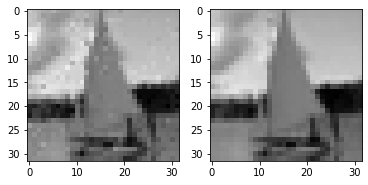

True label: 8
predicted label: 4
Time:  281.46460700035095  seconds
Initial fitness: 
 [-0.28689435389648765, -0.3528039759831423, -0.19069560724337783, -0.021215671025265864, -0.4364556317260841, -0.44649584114562146, -0.3228478587090653, -0.3871555422988091, -0.2661289230097216, -0.3496760354913532, -0.410280558972718, -0.4423832987019941, -0.3647692142753204, -0.21400505829505723, -0.38295331453623604, 0.03748315960383983, 0.006826739451059494, -0.46684678453935585, -0.39961975489615215, -0.2775837213039402, -0.3469875699366992, -0.01292410778210501, -0.49689082733451806, -0.35834296917611663, 0.2390061302626268, -0.3919774215083458, -0.3525550373794285, -0.08933335021607064, 0.14170132323952295, -0.2876737060564263, -0.3507400377668184, -0.33150730007129775, -0.2446293964201239, -0.3327350354524802, -0.27786976112431666, -0.3264072529256762, -0.2918092501367029, -0.07990169443557701, -0.06919643796184424, 0.02701334110662576, -0.38026562426870325, -0.236779892048078, -0.36326003111

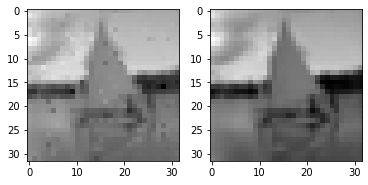

True label: 8
predicted label: 0
Time:  206.1150507926941  seconds
Initial fitness: 
 [-0.6005159005463256, -0.6043634299092768, -0.608402518635075, -0.6105269005845438, -0.6017606911072966, -0.6008154815559131, -0.6022128193987782, -0.6007733077987447, -0.5999723209908866, -0.6058222445572542, -0.600833667403206, -0.6050761188478415, -0.6008512642235273, -0.6030556373630491, -0.601320150940944, -0.6018643385906769, -0.6061930307081947, -0.6034005912897804, -0.6007953325064086, -0.6022318099554428, -0.6017460811261627, -0.6068509795871286, -0.6052279856766676, -0.599951162702411, -0.603737222599577, -0.60259308026919, -0.6038798216519256, -0.6016920764151742, -0.6032199241428073, -0.6017044481840699, -0.605805257439889, -0.6049395813828808, -0.6024052411552465, -0.6044237835945321, -0.6008731564081261, -0.603211983850657, -0.6041703763501757, -0.6072947170062364, -0.6083874893149336, -0.6025229672497765, -0.6004210542652979, -0.6022473004184095, -0.6024354726155051, -0.6000203304777476

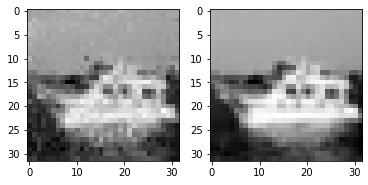

True label: 8
predicted label: 0
Time:  692.0242269039154  seconds
Initial fitness: 
 [-0.599529958827707, -0.5992831884586509, -0.5995969028676122, -0.5995751739930326, -0.5995697591370281, -0.5997205643562465, -0.5997741578178315, -0.5994651343466473, -0.5995499089383013, -0.5994818279562805, -0.5995149777376364, -0.5995861971156584, -0.599578968199541, -0.5996736519886926, -0.5990464089528366, -0.5996491397787854, -0.5995321002173828, -0.5994114288342756, -0.5997778373383806, -0.5996246865220192, -0.5995475494940418, -0.5992572238872792, -0.5995188181040447, -0.5994691843760953, -0.5994085859561199, -0.599667818354936, -0.5996100466937359, -0.5996332803407131, -0.599536597799728, -0.5994736269635418, -0.5996597694350864, -0.5995703187645243, -0.5998851346277787, -0.5998219658744535, -0.5995831188743574, -0.5999965953551449, -0.5995858253108616, -0.5997704509615436, -0.5996583430435221, -0.5993761616182283, -0.5993719471990304, -0.5997038067799212, -0.5995776484702576, -0.59932722337

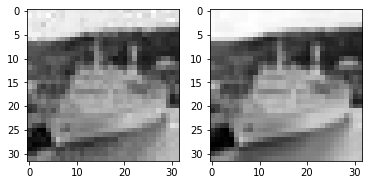

True label: 8
predicted label: 6
Time:  579.6927695274353  seconds
Initial fitness: 
 [-0.5932448402323416, -0.5943480041963864, -0.5919760089491115, -0.5946726274558087, -0.5878545223998808, -0.588991793071179, -0.5887881460986953, -0.5918433160730676, -0.5934137568744804, -0.5940314765055671, -0.5931229267973206, -0.5898584357894522, -0.5897408361567024, -0.5939726215741187, -0.5923022996311571, -0.5868973113558742, -0.5903170472156368, -0.5959220952714765, -0.5872868725166343, -0.5870772170009086, -0.5898407336547631, -0.5817533847558279, -0.5855693752131645, -0.5926868229768933, -0.584771848106795, -0.5937452937691954, -0.5902065210834179, -0.587306503656833, -0.5889599598000613, -0.5884439018640244, -0.5889890281882368, -0.5904703959716079, -0.6000150911152047, -0.589958823058375, -0.5832303904944844, -0.5910825432792427, -0.5903922695729342, -0.59039701323733, -0.5945868246160531, -0.5899600445417219, -0.5962246984177908, -0.5822142227673629, -0.5817251670358395, -0.5882937332206

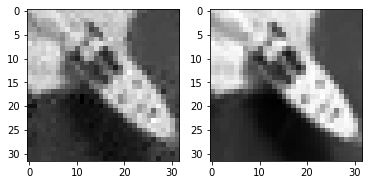

True label: 8
predicted label: 0
Time:  703.8192327022552  seconds
Initial fitness: 
 [-0.605083061321221, -0.5999954877101534, -0.6004360671111161, -0.601712896097378, -0.6003781065839574, -0.6018492951104379, -0.6023890108432152, -0.6040518910821242, -0.6004193342276367, -0.6002554698778587, -0.607617155681391, -0.6004891115735947, -0.6004839675197345, -0.6022498309478703, -0.6021842717833144, -0.6019747307323261, -0.6026078550387235, -0.60119583858731, -0.6028503566778015, -0.6009996044223984, -0.6013225285632935, -0.6020915110016309, -0.6028360067253241, -0.6021395327426164, -0.6009329465994665, -0.6002785451537215, -0.6013669454383522, -0.6001465443042071, -0.6010882010509402, -0.6020507811232351, -0.6018644958636279, -0.6011987463627663, -0.6025388052667804, -0.604603568245124, -0.6029211700235751, -0.6015847952088226, -0.6022998784177324, -0.6014535962678681, -0.6051791198507004, -0.6006336681677972, -0.6013986003462976, -0.6000753092499471, -0.6002188144583394, -0.6025587046516

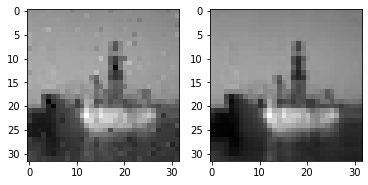

True label: 8
predicted label: 4
Time:  216.3029270172119  seconds
Initial fitness: 
 [-0.5996658634977221, -0.5997005384938596, -0.5999592927530403, -0.5995842661758406, -0.5996498302725429, -0.5997022252866127, -0.5997644954198842, -0.5999689355260431, -0.5998032689446794, -0.5998077037600535, -0.5997079651956285, -0.6001086060045996, -0.6002212164581204, -0.5997737632173767, -0.5995996010642091, -0.5997439081834093, -0.5996950363502254, -0.599773445498619, -0.600077602275634, -0.5998451688601765, -0.5998496987927731, -0.5997964718689424, -0.5999378456191, -0.6001276904125348, -0.5990319633167696, -0.5997325883957221, -0.5995880441501847, -0.5997835574847734, -0.5997403137546097, -0.5999077805093063, -0.5999071709723869, -0.5997461415936934, -0.5994469950296375, -0.5996392510894508, -0.5999414246289648, -0.5996250936009739, -0.599848290316308, -0.5998937208711224, -0.5993217339538289, -0.5996853323393155, -0.5998194703801485, -0.5998072863888081, -0.5995844717484881, -0.6000478881930

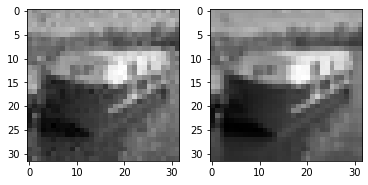

True label: 8
predicted label: 6
Time:  674.2052330970764  seconds
Initial fitness: 
 [-0.23448921739303943, -0.21051520495674153, -0.36619853906540123, -0.10962983331838907, -0.3013818875193961, -0.3393706189203589, -0.44706167512053585, -0.1421083564384159, 0.39755587280162236, -0.2600489314490261, -0.2222487093233359, -0.3081578007090115, -0.4430457432109963, -0.21247654130813504, -0.39304124289111736, -0.407586087682166, -0.22458081541562608, -0.24087130482360666, -0.2920568100335711, -0.25547203450000205, -0.46943277001881534, -0.443075225036955, -0.33198635446555097, -0.35544829390235855, -0.42771548095734707, -0.2458718501048528, -0.24087172293581338, -0.2402850651683876, -0.2911565095046361, -0.3107756616537367, -0.3379723128721578, -0.4425146090037636, -0.3568772405013254, -0.26352709248505335, -0.04660518675375683, -0.2786550106367526, -0.46389317613988457, -0.31421468569148325, -0.24308972892497355, -0.19157494750944648, -0.29403939776708776, -0.31822947714941063, -0.3819111

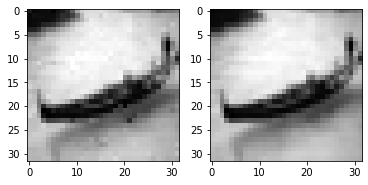

True label: 8
predicted label: 0
Time:  171.2254331111908  seconds
Initial fitness: 
 [-0.6009187691451869, -0.6011587666576277, -0.6000734748118028, -0.6023137380592454, -0.5988475504549936, -0.601176888041418, -0.6007259469191374, -0.6030492864216431, -0.603576901052963, -0.6050298849376685, -0.6027204287096197, -0.6055414706559394, -0.6006217340685408, -0.6021149630947911, -0.6032560975499923, -0.6034728249238024, -0.6012859022148835, -0.6013856550620137, -0.6004227089816058, -0.6047265048453454, -0.6015382085714799, -0.6011544152594488, -0.6012394381435037, -0.6024483458501573, -0.6026917616370442, -0.6044636859296282, -0.5999629643794164, -0.6037470194483587, -0.6041238211873587, -0.6002333819108522, -0.6003187806569581, -0.6048569884911374, -0.6009141977140374, -0.6076966760429744, -0.6004118027974426, -0.6021521722952886, -0.6038628178719583, -0.5999024194230804, -0.6086698788736691, -0.6004199024045401, -0.6020813513552405, -0.5997993930040719, -0.601992719766216, -0.6066937191

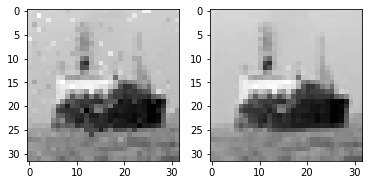

True label: 8
predicted label: 6
Time:  201.14238500595093  seconds
Initial fitness: 
 [-0.6000762475861996, -0.6003149012657881, -0.6002276106934096, -0.6001651669858151, -0.6009368487542668, -0.6001675658784857, -0.6003074556132014, -0.600181062511423, -0.6004640598858497, -0.6004014163668788, -0.6005093231008559, -0.6001718137886718, -0.6001862002438845, -0.6001571700859033, -0.6002229857175462, -0.6002615082193399, -0.6017690046160391, -0.6001050004647631, -0.6001112585265016, -0.600412926193236, -0.6005980670278461, -0.60016306384916, -0.6003665122109364, -0.600092411071747, -0.6006573537345853, -0.6005734871366039, -0.6002828445210001, -0.600973677712053, -0.6004202355215672, -0.6003494918413619, -0.6014454885530793, -0.6000559570487987, -0.6003418613204956, -0.6000808325920411, -0.6001591176814631, -0.6001334551372379, -0.6004574932326697, -0.6001847368486706, -0.6007565744480863, -0.6005863044619553, -0.6001566242838814, -0.6005092142219011, -0.600219692577479, -0.6000423252413

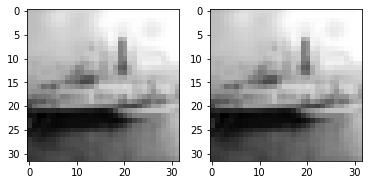

True label: 8
predicted label: 8
Time:  114.33357787132263  seconds
Initial fitness: 
 [-0.5999228466316948, -0.5995618175107728, -0.5993898284933615, -0.599820436871217, -0.5992647699418281, -0.5998543652482538, -0.5997563395246905, -0.5991407109985567, -0.5996084625170143, -0.5997818398236955, -0.5996543402293479, -0.5996326887627282, -0.5994604296216693, -0.5993544389719511, -0.5995198218175932, -0.599471447804439, -0.5990819754714416, -0.5993666055944015, -0.5997417511750298, -0.5994551190279785, -0.5986199924345359, -0.6000108290966191, -0.5992745032034471, -0.5995933045575955, -0.5994378075461535, -0.5994577704764124, -0.5997008917462616, -0.5992073336290614, -0.6000423175930998, -0.5998196989325055, -0.5994877447318989, -0.5997929802205257, -0.5997548312072429, -0.5992295537071027, -0.5995633936963731, -0.5992061185879505, -0.5997236524420774, -0.5995763780268795, -0.5998181914182006, -0.5995381214452639, -0.599942655635213, -0.5998867532962283, -0.5997547004168658, -0.599906240

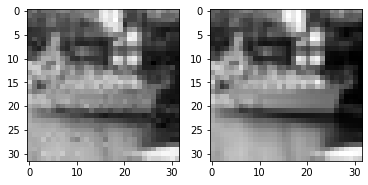

True label: 8
predicted label: 3
Time:  280.4971914291382  seconds
Initial fitness: 
 [-0.6020334645484269, -0.6015130735771944, -0.6015426401494297, -0.6012391480647675, -0.6027164188123176, -0.602962065315171, -0.6007052016647698, -0.6010957945297608, -0.6028028319195475, -0.6032776800384667, -0.6048388038824772, -0.6017741087776411, -0.6052029013772359, -0.6046269798637464, -0.6033573646542456, -0.6031758087379445, -0.6086506239511866, -0.602235803965853, -0.6052324486409325, -0.6035281312602203, -0.6041888907631963, -0.6018595037324511, -0.6055602932513559, -0.6010031780605244, -0.603490256820905, -0.600765702855525, -0.6018931093364359, -0.6068377587058269, -0.601435835858486, -0.6006013500796115, -0.6014076419954073, -0.6029687182542588, -0.6017766189277552, -0.603918259590709, -0.6055934853837849, -0.6038172913353577, -0.602812681287312, -0.6068938117982929, -0.601476679388339, -0.6017347675059692, -0.6042844503523118, -0.6066553142878626, -0.6013453837155074, -0.600805936874657

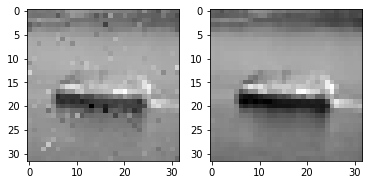

True label: 8
predicted label: 0
Time:  213.1940712928772  seconds
Initial fitness: 
 [-0.5999649915597546, -0.6000208694893614, -0.6000489237534483, -0.6000722778374149, -0.5999621212592475, -0.5999396798301274, -0.6000089531836038, -0.5999689736122106, -0.5999425324287806, -0.5998874909830397, -0.6000637522301511, -0.5999497285542488, -0.5999618833172679, -0.6001867594437936, -0.5999589716308869, -0.5999749692517404, -0.5999127290904165, -0.599978220788707, -0.5999989101364607, -0.5999637965052323, -0.5999574119217742, -0.5998893359362938, -0.5999371619671477, -0.599992630537222, -0.6000245295400118, -0.6000124995224364, -0.600028055026103, -0.6002354028933714, -0.599930956999085, -0.5998857369920555, -0.5999323949918605, -0.5999872718580235, -0.5998917646393842, -0.5999598493279725, -0.6001043194548411, -0.5999823268258798, -0.5999659724950609, -0.6000095128103019, -0.5999104662440987, -0.6000111555560041, -0.5999469153839815, -0.600046395386409, -0.6000004549647598, -0.600175471720

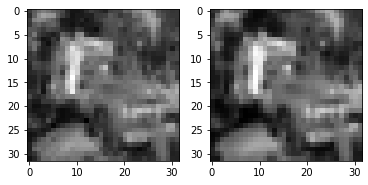

True label: 9
predicted label: 1
Time:  332.61462330818176  seconds
Initial fitness: 
 [-0.11582358200085399, -0.26637284661115146, -0.21434704850070943, -0.1792340957823909, -0.31673875018002307, -0.21001803976851646, -0.16566143220248888, -0.19424479963036292, -0.2761083611509674, -0.25946763435079667, -0.10749880607874401, -0.2773439355297178, -0.1549503670616338, -0.16288595513137533, -0.2978865551423652, -0.2115307084444448, -0.21912060383153736, -0.29285288998354575, -0.391085227002298, -0.17663569800044748, -0.0506311333680059, -0.21995417653248844, -0.18490352917445874, -0.2162373982536552, -0.27329740986595585, -0.24047019135585251, -0.28052354123603535, 0.07276786867189522, -0.12969817143190454, -0.12590954562995665, -0.10637099187348353, -0.2155660689936456, -0.09231026441556678, -0.18747253752609228, -0.36625626207058204, -0.2824204408799532, -0.2737157867364869, -0.19945981760040024, 0.0388777844728887, -0.1304608913581441, -0.247479302292798, -0.26313839946608897, -0.2671

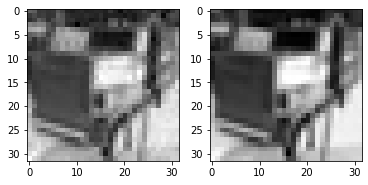

True label: 9
predicted label: 1
Time:  621.9345059394836  seconds
Initial fitness: 
 [-0.5983349913826952, -0.5979874639165506, -0.598190082346272, -0.5984359206927548, -0.5977946608462598, -0.598378701679197, -0.5987636025389882, -0.598138384227287, -0.5979262092833331, -0.5977973265020994, -0.5968790553948566, -0.597702596158616, -0.5981382319198244, -0.5983191847172089, -0.59822411058229, -0.5976523778425332, -0.59759251128286, -0.5966390758472988, -0.5960621479389248, -0.5984866934347501, -0.5993567050252187, -0.5984947055415284, -0.5984309274334396, -0.5981460200869408, -0.5963094223684975, -0.5978432962465944, -0.5983084253997774, -0.5971022406605762, -0.5977500683324226, -0.5990023734684563, -0.5986965245601796, -0.5979029716658689, -0.5977188152254852, -0.5987870960852648, -0.5978302371255496, -0.5979973501139578, -0.5993110305049532, -0.598389981462975, -0.5984843975905204, -0.5978627251708918, -0.5978383134179802, -0.5979349279930792, -0.5981201164961081, -0.5985981588725192

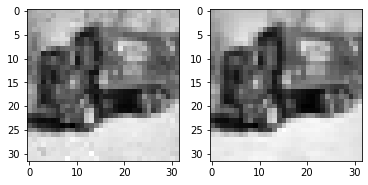

True label: 9
predicted label: 1
Time:  359.00675988197327  seconds
Initial fitness: 
 [-0.6010589465627741, -0.6027464164977396, -0.6009112596773891, -0.6003327335123934, -0.6120013540559393, -0.6018112114905954, -0.600518408498824, -0.6021156753929722, -0.5999561066572738, -0.6059552433284069, -0.6026419933778193, -0.6004223135568566, -0.5999548762410742, -0.5998799201060102, -0.6074546008454715, -0.6026589602343557, -0.6000266061033318, -0.6005377479548087, -0.6021169887535243, -0.6010828875436202, -0.5999240756977466, -0.6000383830052816, -0.601247962270436, -0.6003928947572564, -0.600556386270591, -0.6045646456455817, -0.6009446054582922, -0.604460072193058, -0.6029462605758547, -0.602569186317486, -0.6000197110205757, -0.6003760347449834, -0.6007011986314522, -0.6001514794252618, -0.6033494267582613, -0.6056664532257814, -0.6006663530288325, -0.6038278534193551, -0.6024665557541701, -0.6000232959828017, -0.608742974008732, -0.6019735412493451, -0.6024631918711684, -0.602675126983

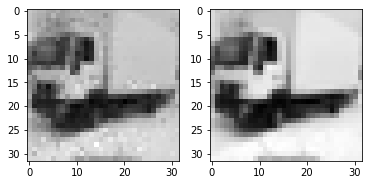

True label: 9
predicted label: 8
Time:  365.9862537384033  seconds
Initial fitness: 
 [-0.60004750621602, -0.6015727573268828, -0.60110618122039, -0.5999831103546822, -0.5998537472217667, -0.6008734427214482, -0.602558235540426, -0.5995299407715566, -0.6005374615155832, -0.5997593404987593, -0.5996306201409599, -0.6026971136893304, -0.6002126858452304, -0.6009633529248262, -0.5999742460349452, -0.6006019671556846, -0.6005122399168494, -0.6006095749293977, -0.6021951007155345, -0.5998396953513048, -0.5996465040020051, -0.604929481864428, -0.6040076093986168, -0.5997488507937119, -0.6041698375182771, -0.6017274937445649, -0.6032601143565308, -0.5998954321091537, -0.5999509924390437, -0.6006511184600227, -0.5997597973471679, -0.6015844934038747, -0.6039896644645032, -0.6014871642729303, -0.602864880696561, -0.5997777381894253, -0.6000362249466871, -0.601398685311009, -0.6068768391784842, -0.5998486220886805, -0.6004401691327822, -0.5996198407871884, -0.6000759393227623, -0.599851147386902

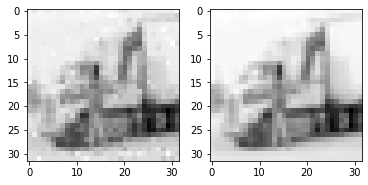

True label: 9
predicted label: 8
Time:  264.75890040397644  seconds
Initial fitness: 
 [-0.6004741371111276, -0.6002659841856473, -0.6000665508136421, -0.6001761616893796, -0.6001607291527764, -0.6001187359895436, -0.6000804733420627, -0.6001021094515562, -0.6001000325765461, -0.600226988615552, -0.6001086458710584, -0.6001072330592045, -0.6002186217775155, -0.6001651249473289, -0.6000459062453747, -0.6001148820863267, -0.6001318885794753, -0.6000227665835726, -0.6002542622141629, -0.6000716250196527, -0.6000591188827438, -0.6001119104279631, -0.6001249241263227, -0.6000109538783693, -0.6001196795945962, -0.6000559276870767, -0.600140786687738, -0.6004344763252023, -0.6001800164583988, -0.600133429136161, -0.6007031179888433, -0.6000852523537206, -0.6000600569589485, -0.600510000974946, -0.6000182157404114, -0.6001125907913022, -0.6001966511253818, -0.6006762257849653, -0.6001053031173684, -0.6000841482664434, -0.6001180592711768, -0.6003712597060992, -0.600035212287627, -0.60015190188

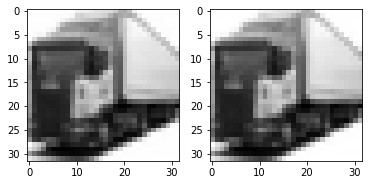

True label: 9
predicted label: 9
Time:  90.92280197143555  seconds
Initial fitness: 
 [-0.4561461198594233, -0.4595734989718431, -0.4825343651236168, -0.5123360500922508, -0.4601959795909253, -0.4889011528951402, -0.3503857733307286, -0.5110012207238493, -0.44833079157751277, -0.5016882714198293, -0.49838321685354325, -0.469785965409514, -0.4693178618303194, -0.43692267325986234, -0.4701535947952181, -0.5025193678037552, -0.5121372425600603, -0.49380394702009217, -0.4811428314728889, -0.48210963980270005, -0.46377001244312877, -0.505395747854368, -0.48664557277054354, -0.45135466752196773, -0.47539999229504226, -0.48779522033929534, -0.5583572174918914, -0.43955648960974913, -0.49184267582290975, -0.4820105699889634, -0.5058111417508157, -0.4773318609470688, -0.4900263714981067, -0.4545860625516913, -0.47810350009559144, -0.5051860504420516, -0.5022810801893957, -0.46122407222354456, -0.45736432968147644, -0.5017373753447226, -0.473881600873321, -0.4900563038544017, -0.4599040576450364

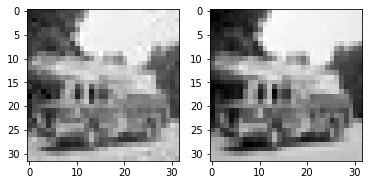

True label: 9
predicted label: 1
Time:  419.29170179367065  seconds
Initial fitness: 
 [-0.599919693699715, -0.5999904144769246, -0.5999517662006312, -0.5998454731399935, -0.5997901868056438, -0.6001184504203639, -0.599988267885259, -0.5998280921151605, -0.5998782109066205, -0.5998888205320445, -0.5998318304561876, -0.5996685486427364, -0.599758943265279, -0.5999616677289551, -0.5997579209048721, -0.5997672452452907, -0.599825673727969, -0.5998664359737623, -0.5998729701133361, -0.599791759745902, -0.5997793304837274, -0.5998652449895191, -0.5998280348974466, -0.599929476597763, -0.5999439640890721, -0.5997660996560121, -0.599870904028087, -0.5998927955030633, -0.5998655797766037, -0.599792334861404, -0.5998704701723585, -0.5997546190867427, -0.6000214836673676, -0.5998584346195347, -0.5999514387901655, -0.5998113324130163, -0.5999608204687932, -0.5998592392624278, -0.599940067537653, -0.5998139163340044, -0.599820938661829, -0.5998933349863875, -0.5999843902479012, -0.5997794209799838

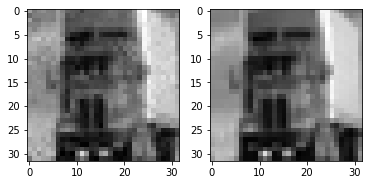

True label: 9
predicted label: 1
Time:  577.65309882164  seconds
Initial fitness: 
 [-0.5165462589658563, -0.49760991816505384, -0.5238854723906428, -0.5341637610064688, -0.5423198591825246, -0.5133468920063491, -0.5159823487954194, -0.5194657187089453, -0.5242331073629112, -0.5074941561367907, -0.5071041110220005, -0.5364555826875923, -0.49759941309372624, -0.54283244964724, -0.48230758461258183, -0.4941439903819159, -0.5427741238854898, -0.5224394041819117, -0.5165389157444944, -0.5177258593498866, -0.5227969075224356, -0.5120465032152391, -0.5180610460356826, -0.5193644548013127, -0.49287252543956345, -0.5213432039370485, -0.49598434273773795, -0.5232515487828422, -0.49172302768852055, -0.5221336801319305, -0.5237768387301552, -0.513399836700677, -0.513486054299517, -0.504777691325055, -0.5382517202131025, -0.5324232034091608, -0.5322337254949239, -0.5309323914711839, -0.511381913845778, -0.5363931638656234, -0.5231965385354691, -0.46433794048422716, -0.5153900759708233, -0.52427015

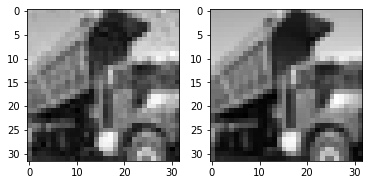

True label: 9
predicted label: 2
Time:  552.9521186351776  seconds
Initial fitness: 
 [-0.5977113239731265, -0.598399705854638, -0.5973849798375289, -0.5982663027135912, -0.5983889100771521, -0.5982303105990008, -0.5978283705372603, -0.5984216260520375, -0.5975871552082884, -0.598966116716635, -0.5983751177167002, -0.5976741706018214, -0.593129424360444, -0.595233335601064, -0.597514112054505, -0.5989681869524197, -0.5980946101214338, -0.5990289116479107, -0.5945978738212598, -0.5982663622271913, -0.5993215845038693, -0.597063378663892, -0.5972875146288964, -0.5986648425683999, -0.5988832325020008, -0.5972378146809901, -0.5978507767263657, -0.5978803104546107, -0.5989904608143989, -0.5994330345659187, -0.5988575308085818, -0.5977792718068488, -0.5970100083421214, -0.5994426162999015, -0.5979043112989016, -0.5987615439323604, -0.5985612491676656, -0.5987633883439131, -0.5987274689997795, -0.5981713333328444, -0.5968387960472787, -0.5974041880363968, -0.5990014409530158, -0.5975854089214

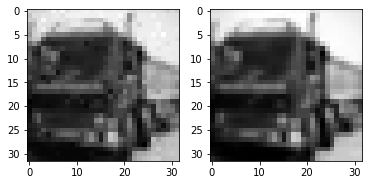

True label: 9
predicted label: 1
Time:  230.5584900379181  seconds
Initial fitness: 
 [0.1557292834217774, 0.1455694094280891, 0.1521959399308651, -0.1577810373968917, 0.17771695614973743, 0.07577521536899239, 0.38963682070516487, 0.02475922910579345, 0.0790574864491333, 0.11348618823219103, 0.13270746930666955, 0.16100139891877682, 0.17320446128394051, 0.1807303189757542, 0.1495382663497387, -0.012579576994702829, 0.1367790111144579, 0.11881526618826938, 0.15885776199240526, -0.08731377222388056, 0.02780272547022289, 0.1313241161789751, 0.12609627537518914, -0.004436718552031871, -0.017189972918463553, 0.07580806367834107, 0.10799147432182615, 0.30816267428060706, -0.09748237726814735, 0.24277600053813492, -0.02157578675306257, 0.11236524804130783, 0.0053825963373733965, 0.11210273959759127, -0.043703160295557486, 0.08180353596224353, 0.21332905916966763, 0.08917747845307916, -0.022582932198396855, 0.11316182302837441, 0.2079125038952044, 0.12625592665056382, 0.10434501420986779, 0.04

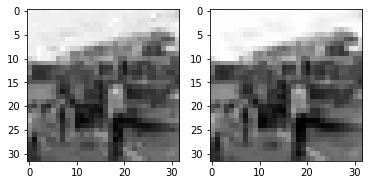

True label: 9
predicted label: 7
Time:  235.22330713272095  seconds
Initial fitness: 
 [-0.6003264421521879, -0.6002019894688575, -0.6007467537995526, -0.6001999236204926, -0.6010307385658632, -0.6001516481108352, -0.6006174628365492, -0.6009757069411937, -0.6002868904746337, -0.6003582128599358, -0.6010276650991168, -0.599987273948063, -0.6016219249518158, -0.5999761875640365, -0.6003520820923753, -0.6020020145196663, -0.600134334347424, -0.6003551532929987, -0.6000415643899367, -0.6019345910266979, -0.6006728679048154, -0.6009946823453576, -0.6004607995848166, -0.6000108771093356, -0.6010402053877283, -0.6009028685657936, -0.6002406286511355, -0.6001005781110866, -0.6001436670784591, -0.6006303565577299, -0.6007633257116706, -0.6003786231488848, -0.5999873669864658, -0.6000323715872439, -0.6025238436032221, -0.6000930298313722, -0.6001363919862553, -0.600341000419206, -0.6028244894468902, -0.6005426867118279, -0.6004394155724937, -0.601722936138428, -0.6003764544303101, -0.6016962856

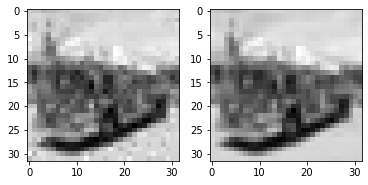

True label: 9
predicted label: 6
Time:  289.7728159427643  seconds
Initial fitness: 
 [-0.6001279912977838, -0.6001223759023178, -0.6000922527128396, -0.6006522191237508, -0.6000594975540312, -0.6006649186094505, -0.5999896427436122, -0.6000260480811825, -0.6000311028834947, -0.6002146799725374, -0.6000437092595237, -0.6003627531723292, -0.6000034097338101, -0.6001922979528063, -0.6002415056861139, -0.600445291979117, -0.6002648839866019, -0.6002041009682322, -0.6002405428903946, -0.6002686259197821, -0.6003010023651028, -0.6001143339207498, -0.6005974869787944, -0.6000212908187734, -0.6000359175036012, -0.60019655038317, -0.6000017504602319, -0.6002544874031007, -0.6002024659053721, -0.6004533552982759, -0.6000545430776332, -0.6001894020346871, -0.6001428608906176, -0.600086511731057, -0.6001682957502659, -0.6001820980660652, -0.6001581904843383, -0.6001626464560481, -0.6000880761511046, -0.6001268918375272, -0.6002406259159704, -0.6000530805619636, -0.6000827263279973, -0.60043819549

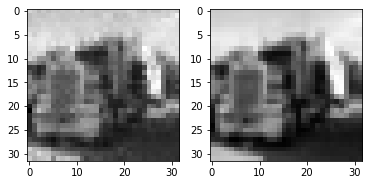

True label: 9
predicted label: 8
Time:  1001.166188955307  seconds
Initial fitness: 
 [0.36453154161634815, 0.3103749024347218, 0.4710646091495063, 0.39555797631628786, 0.4261621348058131, 0.39171908771271713, 0.2247072669640589, 0.3979270051378236, 0.35234398193946415, 0.492422432393432, 0.40799914181878716, 0.30229721241619056, 0.320862884718052, 0.4060284933421362, 0.48085711657331387, 0.3532263202716305, 0.31215492287525737, 0.25470887826490585, 0.2160620711298154, 0.39667865256629853, 0.4071772258033085, 0.30092967828319594, 0.27253018926859485, 0.28872081586538834, 0.2817759607385175, 0.5585223408253867, 0.06790497805779339, 0.44225433403906905, 0.3355414291445416, 0.2084743335264452, 0.41742402675442736, 0.4595370677593699, 0.534273790299189, 0.36557329901334, 0.45503775731817475, 0.3523397802161451, 0.23959742965163555, 0.4559936543408723, 0.3933341920431943, 0.37522290178471523, 0.46201337322418184, 0.18593326689074507, 0.24054553353966873, 0.23924385995935185, 0.3219652384962

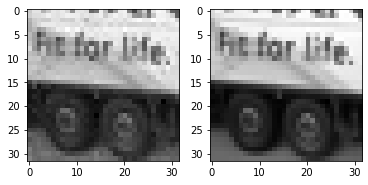

True label: 9
predicted label: 1
Time:  326.156898021698  seconds


In [14]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)
  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = quadrant_crossover(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




In [15]:
np.argmin(number_of_rounds)

59

# Save files


In [16]:
import pickle
file_ = open('GA_adv_cifar_quadrant_seed1', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 1488.9877593517303
Min time: 4.574310302734375
Mean time: 406.0116240798979
Std time: 247.3506511489888

Max fitness evolved: 0.9983096022419197
Min fitness evolved:: -0.6042070739182456
Mean fitness evolved: 0.8666499048940923
Std fitness evolved:: 0.42156323923113653

Max ssim: 0.34190895206773864
Min ssim: 2.7435036020762027e-08
Mean ssim: 0.04055395217148755
Std ssim: 0.04433170016050515

Max rounds: 332
Min rounds: 0
Mean rounds: 98.90977443609023
Std rounds: 61.92955719877496

Percentage of adversarial founds sucessfully : 0.015037593984962405 %
Percentage of adversarial founds after fitness not improving for 30 generations: 0.9849624060150376 %


Open adversarial

In [17]:
with open('GA_adv_cifar_quadrant_seed1', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [18]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.999999972564964
Min ssim: 0.6580910479322614
Mean ssim: 0.9594460478285124
Std ssim: 0.04433170016050516



In [19]:
#change 0 to 1 in the np.array
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 

In [20]:
number_of_rounds

array([ 83,  67,  60, 161,  49,  54, 293, 201, 117,  48,  61,  42, 108,
       161,  74,  30,  53,  48,  69, 107,  50,  30,  76,  30,  30, 283,
        53,  49,  58, 157,  47,  68, 159, 102, 141,  51,  30, 203,  30,
        38,  54, 102, 139,  74,  57, 117,  64, 129, 117, 217,  63,  62,
        30,  56,  70,  76,  39,  52,  59,   1, 124,  64,  84, 103,  55,
        46,  51, 116,  46, 182,  68,  49,  83,  94, 139,   1, 141, 198,
       150,  46,  30, 109,  54, 244,  84, 120, 180,  99, 164,  89, 197,
        55, 203, 281, 104, 135,  92, 137, 104,  50,  55,  69,  94, 138,
       108, 121, 154,  74,  54, 178, 153, 186,  57, 178,  45,  53,  30,
        74,  56,  88, 164,  95,  95,  78,  30, 139, 192, 184,  76,  78,
        96, 332, 113])

In [21]:
print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")

Max rounds: 332
Min rounds: 1
Mean rounds: 98.92481203007519
Std rounds: 61.90565512328307



# Examples of what functions do

In [22]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

[-0.798671082694986, -0.7987041848156723, -0.7985519129101214, -0.7986431364272846, -0.7985392121306405, -0.7986301764981845, -0.7987035336173277, -0.7986633261013656, -0.7987039183005314, -0.7987637976269558, -0.7986362304708735, -0.7984971303074706, -0.7984692869181504, -0.7984679817187376, -0.7986864535797377, -0.7985391703395119, -0.7986552051627269, -0.7989991428248503, -0.7987922738456452, -0.7985194393993446, -0.7986910267719595, -0.7987250876200409, -0.798511401726725, -0.7981278774194067, -0.7987422596217473, -0.7985101999050827, -0.7988512267012694, -0.7992738849816521, -0.798640816434461, -0.7986514778778167, -0.7986447197491812, -0.7986043990046967, -0.7985052340720816, -0.7986601148979449, -0.7989287837675221, -0.7988489130153938, -0.7985274565853867, -0.798661884240478, -0.7986058809503074, -0.7988424638520428, -0.7987363387397479, -0.7985667720191123, -0.7985866404521724, -0.7987210271155063, -0.7986796841853254, -0.7987182036289542, -0.7988048834900796, -0.7978805170212

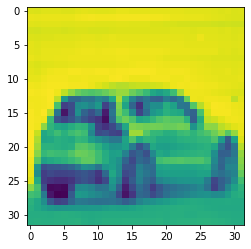

Class for this 1
[[2.5409783e-10 1.0000000e+00 8.0901038e-14 4.2946185e-12 4.8692419e-13
  1.2974909e-13 1.0352755e-12 6.9071897e-13 2.1462630e-13 4.3407198e-08]]


In [23]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [24]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

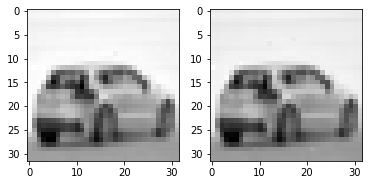

In [25]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [26]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

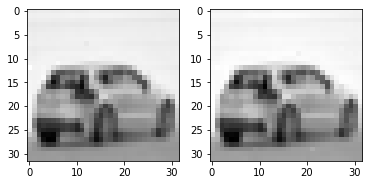

In [27]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [28]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

diff between children [-12.7769165   -9.955032    -7.9433975   -7.4239807   -6.410446
  -4.5699463   -4.3742065   -2.9933472   -0.8643341    0.
   0.18969727   4.841614     6.1235523    6.7919617    9.881699
  11.532028    11.607269  ]
diff between parents [-11.607269   -11.532028    -9.955032    -9.881699    -6.7919617
  -6.410446    -6.1235523   -4.841614    -0.7054901   -0.5733032
  -0.18969727   0.           0.8643341    1.8760986    2.9933472
   4.0457       4.3742065    4.5699463    6.7281647    7.4239807
   7.9433975   12.7769165 ]
diff between p1 and c1 [-11.607269   -11.532028    -9.881699    -6.7919617   -6.1235523
  -4.841614    -0.18969727   0.           0.8643341    1.8760986
   2.9933472    4.0457       4.3742065    4.5699463    7.4239807
   7.9433975   12.7769165 ]
diff between p1 and c2 [-9.955032  -6.410446   0.         1.8760986  4.0457   ]
diff between p2 and c1 [-6.7281647  0.         0.5733032  0.7054901  6.410446   9.955032 ]
diff between p2 and c2 [-12.7769165   

In [29]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

In [30]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

[0.8013288219375824, 0.8012957198168961, 0.8014480870898787, 0.8013567682052838, 0.8014606925019279, 0.8013697281343839, 0.8012961802803774, 0.8013363877963395, 0.8012959863320369, 0.8012359162707493, 0.8013634834268316, 0.8015027743250978, 0.8015302362446914, 0.8015319229138308, 0.8013134510528307, 0.8014605435581932, 0.8013446994698414, 0.8010005710728548, 0.8012076307869231, 0.8014804652332238, 0.8013088778606089, 0.8012745309102327, 0.8014883121709802, 0.8018717411108669, 0.8012576450108211, 0.8014897047274857, 0.801148677931299, 0.8007260196509163, 0.8013590881981073, 0.8013482360198885, 0.8013551848833872, 0.8013955056278717, 0.801494384458192, 0.8013395989997603, 0.8010711208650463, 0.8011508008823113, 0.8014724480471817, 0.8013380203920903, 0.8013937375799662, 0.8011571546782308, 0.8012636612602522, 0.8014332279808878, 0.8014132641803959, 0.8012788775170621, 0.8013200297123797, 0.8012817010036142, 0.8011950211424888, 0.8021191015089956, 0.8017082430326797, 0.8012830035396182]
